-----------

Deep Learning
------------
Assignment 3
-----

Previously in 2_fullyconnected.ipynb, you trained a logistic regression and a neural network model.
The goal of this assignment is to explore regularization techniques.

-------------

In [2]:
import numpy as np
import tensorflow as tf
import cPickle as pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
PKL_FILE = 'notMNIST.pickle'
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_PIXELS = IMG_HEIGHT * IMG_WIDTH
NUM_CLASSES = 10

with open(PKL_FILE, 'rb') as f:
    save_file = pickle.load(f)
    train_dataset = save_file['train_dataset']
    train_labels  = save_file['train_labels']
    test_dataset  = save_file['test_dataset']
    test_labels   = save_file['test_labels']
    val_dataset   = save_file['valid_dataset']
    val_labels    = save_file['valid_labels']
    
    del save_file
    
print 'Training', train_dataset.shape, train_labels.shape
print 'Test', test_dataset.shape, test_labels.shape
print 'Validation', val_dataset.shape, val_labels.shape

def reformat_dataset(dataset):
    return dataset.reshape(-1, IMG_HEIGHT * IMG_WIDTH).astype(np.float32)

def one_hot_encode(labels):
    if(len(labels.shape) > 1):
        raise Exception('labels should be a vector')
    return (np.arange(NUM_CLASSES) == labels.reshape(-1, 1)).astype(np.float32)

train_dataset = reformat_dataset(train_dataset)
train_labels  = one_hot_encode(train_labels)
test_dataset  = reformat_dataset(test_dataset)
test_labels   = one_hot_encode(test_labels)
val_dataset   = reformat_dataset(val_dataset)
val_labels    = one_hot_encode(val_labels)

print 'Training', train_dataset.shape, train_labels.shape
print 'Test', test_dataset.shape, test_labels.shape
print 'Validation', val_dataset.shape, val_labels.shape

Training (200000, 28, 28) (200000,)
Test (10000, 28, 28) (10000,)
Validation (10000, 28, 28) (10000,)
Training (200000, 784) (200000, 10)
Test (10000, 784) (10000, 10)
Validation (10000, 784) (10000, 10)


In [146]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])


def train_funciton(graph, train_data, val_data, test_data, training_steps = 3500, batch_size = 128, keep_prob = None):
    
    train_dataset, train_labels = train_data
    val_dataset, val_labels = val_data
    test_dataset, test_labels = test_data
    
    train_dataset_size = train_dataset.shape[0]

    training_hist = []
    validation_hist = []
    loss_hist = []
    start = time.time()
    with tf.Session(graph = graph) as sess:
        init = tf.initialize_all_variables()
        sess.run(init)
        for step in range(training_steps):
            sample = np.random.choice(np.arange(train_dataset_size), 128)
            data_batch = train_dataset[sample]
            label_batch = train_labels[sample]
            feed_dict = { tf_train_dataset : data_batch, 
                          tf_train_labels  : label_batch }
            if keep_prob is not None: 
                feed_dict.update( {tf_keep_prob : keep_prob} )
            _, loss_score, pred = sess.run([opt, loss, predictions], feed_dict = feed_dict)
            if step % 250 == 0:
         
                #log results
                feed_dict = {tf_train_dataset : val_dataset}
                if keep_prob is not None: 
                    feed_dict.update( {tf_keep_prob : 1.0} )
                valid_pred = sess.run(predictions, feed_dict = feed_dict)
                train_acc = accuracy(pred, label_batch)
                val_acc = accuracy(valid_pred, val_labels)
                training_hist.append(train_acc)
                validation_hist.append(val_acc)
                loss_hist.append(loss_score)
                
                print 'Loss at step: ', step, loss_score,
                print 'Train Acc', train_acc, #biased
                print 'Valid Acc', val_acc
                print 'Elapsed Time', time.time() - start
                
        feed_dict = {tf_train_dataset : test_dataset}
        if keep_prob is not None: 
            feed_dict.update( {tf_keep_prob : 1.0} )
        test_pred = sess.run(predictions, feed_dict = feed_dict)    
        print 'Test Accuracy', accuracy(test_pred, test_labels)
        final_w1 = w1.eval()
        final_w2 = w2.eval()
    print 'Runtime', time.time() - start
    return training_hist,  validation_hist, loss_hist, [final_w1, final_w2]


In [37]:

logreg_cls = tf.Graph()
with logreg_cls.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))

    weights = tf.Variable(tf.truncated_normal( shape = (IMG_PIXELS, NUM_CLASSES)))
    biases = tf.Variable(tf.zeros([NUM_CLASSES]))
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)
    ) 
    opt = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    predictions = tf.nn.softmax(logits)
    

In [38]:
train_funciton(logreg_cls,      (train_dataset, train_labels), (val_dataset, val_labels), (test_dataset, test_labels))

Loss at step:  0 16.7557 Train Acc 9.375 Valid Acc 10.63
Elapsed Time 0.077378988266
Loss at step:  1000 1.5062 Train Acc 78.125 Valid Acc 76.51
Elapsed Time 1.62354588509
Loss at step:  2000 1.07067 Train Acc 78.90625 Valid Acc 76.39
Elapsed Time 3.20042181015
Loss at step:  3000 0.651698 Train Acc 85.15625 Valid Acc 78.3
Elapsed Time 4.73201394081
Test Accuracy 86.38
Runtime 5.49288392067


In [40]:
#minibatch training with SGD and xavier_initializer

minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))   
    
    w1 = tf.get_variable("W1", shape = (IMG_PIXELS, 1024), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.truncated_normal(shape = [1024], mean = 0.1, stddev=0.05))
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    
    w2 = tf.get_variable("W2", shape = (1024, NUM_CLASSES), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.truncated_normal(shape = [NUM_CLASSES], mean = 0.1, stddev=0.05))
    logits = tf.matmul(h1, w2) + b2
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)
    ) 
    opt = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    predictions = tf.nn.softmax(logits)


In [41]:
train_funciton(minibatch_graph, (train_dataset, train_labels), (val_dataset, val_labels), (test_dataset, test_labels))

Loss at step:  0 2.42349 Train Acc 16.40625 Valid Acc 33.52
Elapsed Time 0.503674983978
Loss at step:  1000 0.36868 Train Acc 88.28125 Valid Acc 84.95
Elapsed Time 18.193710804
Loss at step:  2000 0.573032 Train Acc 84.375 Valid Acc 86.36
Elapsed Time 37.2031228542
Loss at step:  3000 0.473131 Train Acc 87.5 Valid Acc 87.14
Elapsed Time 58.5359108448
Test Accuracy 93.85
Runtime 68.4252250195


----------------
Problem 1
---------

Both Models with L2 regularizations

---------------------

In [51]:


logreg_cls = tf.Graph()
with logreg_cls.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))

    weights = tf.Variable(tf.truncated_normal( shape = (IMG_PIXELS, NUM_CLASSES)))
    biases = tf.Variable(tf.zeros([NUM_CLASSES]))
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
                  tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)
                + 0.001*tf.nn.l2_loss(weights)
                + 0.001*tf.nn.l2_loss(biases)
    ) 
    opt = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    predictions = tf.nn.softmax(logits)

In [52]:
train_funciton(logreg_cls,      (train_dataset, train_labels), (val_dataset, val_labels), (test_dataset, test_labels))

Loss at step:  0 21.1869 Train Acc 13.28125 Valid Acc 14.75
Elapsed Time 0.118414878845
Loss at step:  1000 1.79979 Train Acc 75.0 Valid Acc 78.71
Elapsed Time 1.98749184608
Loss at step:  2000 0.779604 Train Acc 85.9375 Valid Acc 80.9
Elapsed Time 4.23127698898
Loss at step:  3000 0.80694 Train Acc 78.90625 Valid Acc 81.95
Elapsed Time 6.2738878727
Test Accuracy 88.14
Runtime 7.29902386665


In [54]:
# minibatch training with SGD and xavier_initializer
# adding l2_loss
minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))   
    
    w1 = tf.get_variable("w1", shape = (IMG_PIXELS, 1024), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.truncated_normal(shape = [1024], mean = 0.1, stddev=0.05))
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    
    w2 = tf.get_variable("w2", shape = (1024, NUM_CLASSES), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.truncated_normal(shape = [NUM_CLASSES], mean = 0.1, stddev=0.05))
    logits = tf.matmul(h1, w2) + b2
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)
                + sum([0.001*tf.nn.l2_loss(var) for var in [w1, b1, w2, b2]])
    ) 
    opt = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    predictions = tf.nn.softmax(logits)

train_funciton(minibatch_graph, (train_dataset, train_labels), (val_dataset, val_labels), (test_dataset, test_labels))

Loss at step:  0 2.7694 Train Acc 14.84375 Valid Acc 29.66
Elapsed Time 0.579170942307
Loss at step:  1000 1.06257 Train Acc 77.34375 Valid Acc 85.08
Elapsed Time 21.9710218906
Loss at step:  2000 0.866328 Train Acc 84.375 Valid Acc 86.07
Elapsed Time 42.2306220531
Loss at step:  3000 0.669837 Train Acc 91.40625 Valid Acc 86.64
Elapsed Time 63.7493958473
Test Accuracy 93.67
Runtime 74.8702988625


----------------
Problem 2
---------

Show Example of extreme overfitting on Neural Net, by restricting size of training set to 250 samples

---------------------

In [95]:
# minibatch training with SGD and xavier_initializer
# adding l2_loss
minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))   
    
    w1 = tf.get_variable("w1", shape = (IMG_PIXELS, 1024), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.truncated_normal(shape = [1024], mean = 0.1, stddev=0.05))
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    
    w2 = tf.get_variable("w2", shape = (1024, NUM_CLASSES), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.truncated_normal(shape = [NUM_CLASSES], mean = 0.1, stddev=0.05))
    logits = tf.matmul(h1, w2) + b2
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)
                + sum([0.001*tf.nn.l2_loss(var) for var in [w1, b1, w2, b2]])
    ) 
    opt = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    predictions = tf.nn.softmax(logits)

train_funciton(minibatch_graph, (train_dataset[:1000], train_labels[:1000]), (val_dataset, val_labels), (test_dataset, test_labels),
               training_steps = 2500)

Loss at step:  0 2.84226 Train Acc 8.59375 Valid Acc 37.37
Elapsed Time 0.677483081818
Loss at step:  250 0.638673 Train Acc 96.09375 Valid Acc 80.12
Elapsed Time 6.70847392082
Loss at step:  500 0.491892 Train Acc 100.0 Valid Acc 79.75
Elapsed Time 13.2064459324
Loss at step:  750 0.456131 Train Acc 100.0 Valid Acc 79.83
Elapsed Time 19.7044939995
Loss at step:  1000 0.435523 Train Acc 100.0 Valid Acc 79.91
Elapsed Time 25.4058439732
Loss at step:  1250 0.414433 Train Acc 100.0 Valid Acc 79.91
Elapsed Time 31.2852270603
Loss at step:  1500 0.40494 Train Acc 100.0 Valid Acc 79.75
Elapsed Time 37.0883350372
Loss at step:  1750 0.378938 Train Acc 100.0 Valid Acc 79.86
Elapsed Time 44.2505810261
Loss at step:  2000 0.368866 Train Acc 100.0 Valid Acc 79.81
Elapsed Time 50.7839701176
Loss at step:  2250 0.348609 Train Acc 100.0 Valid Acc 79.86
Elapsed Time 56.5562970638
Test Accuracy 87.64
Runtime 62.4089100361


----------------
Problem 3
---------

Apply Drop Out to overfitting models

---------------------

In [96]:
# minibatch training with SGD and xavier_initializer
# adding l2_loss

minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))
    tf_keep_prob = tf.placeholder(tf.float32, name = "tf_keep_prob")
    
    tf_train_dataset_drop = tf.nn.dropout(tf_train_dataset, tf_keep_prob)
    
    w1 = tf.get_variable("w1", shape = (IMG_PIXELS, 1024), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.truncated_normal(shape = [1024], mean = 0.1, stddev=0.05))
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    h1_drop = tf.nn.dropout(h1, tf_keep_prob)
    
    w2 = tf.get_variable("w2", shape = (1024, NUM_CLASSES), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.truncated_normal(shape = [NUM_CLASSES], mean = 0.1, stddev=0.05))
    logits = tf.matmul(h1_drop, w2) + b2
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)
                + sum([0.001*tf.nn.l2_loss(var) for var in [w1, b1, w2, b2]])
    ) 
    opt = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    predictions = tf.nn.softmax(logits)

train_funciton(minibatch_graph, (train_dataset[:1000], train_labels[:1000]), (val_dataset, val_labels), (test_dataset, test_labels), 
               training_steps = 2500,
               keep_prob=0.25)

Loss at step:  0 3.26677 Train Acc 10.9375 Valid Acc 30.48
Elapsed Time 0.701229095459
Loss at step:  250 0.776806 Train Acc 92.1875 Valid Acc 80.85
Elapsed Time 6.96438217163
Loss at step:  500 0.537247 Train Acc 99.21875 Valid Acc 80.59
Elapsed Time 13.2308599949
Loss at step:  750 0.483926 Train Acc 100.0 Valid Acc 80.71
Elapsed Time 19.6275060177
Loss at step:  1000 0.444466 Train Acc 100.0 Valid Acc 80.67
Elapsed Time 25.8170771599
Loss at step:  1250 0.446604 Train Acc 100.0 Valid Acc 80.77
Elapsed Time 31.9971501827
Loss at step:  1500 0.4281 Train Acc 99.21875 Valid Acc 80.67
Elapsed Time 38.1214680672
Loss at step:  1750 0.394814 Train Acc 100.0 Valid Acc 80.75
Elapsed Time 44.3096921444
Loss at step:  2000 0.374328 Train Acc 100.0 Valid Acc 80.67
Elapsed Time 50.4642031193
Loss at step:  2250 0.369953 Train Acc 100.0 Valid Acc 80.71
Elapsed Time 56.6000540257
Test Accuracy 88.23
Runtime 62.7761850357


----------------
Problem 4
---------

Try for Best Possible Performance

---------------------

In [161]:
# minibatch training with SGD and xavier_initializer
# adding l2_loss

layer_1_size = 2048
layer_2_size = 2048


minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))
    tf_keep_prob = tf.placeholder(tf.float32, name = "tf_keep_prob")
    
    tf_train_dataset_drop = tf.nn.dropout(tf_train_dataset, tf_keep_prob)
    
    w1 = tf.get_variable("w1", shape = (IMG_PIXELS, layer_1_size), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.truncated_normal(shape = [layer_1_size], mean = 0.1, stddev=0.05))
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    h1_drop = tf.nn.dropout(h1, tf_keep_prob)
    
    w2 = tf.get_variable("w2", shape = (layer_1_size, layer_2_size), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.truncated_normal(shape = [layer_2_size], mean = 0.1, stddev=0.05))
    h2 = tf.nn.relu(tf.matmul(h1_drop, w2) + b2)
    h2_drop = tf.nn.dropout(h2, tf_keep_prob)
    
    w3 = tf.get_variable("w3", shape = (layer_2_size, NUM_CLASSES), initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.Variable(tf.truncated_normal(shape = [NUM_CLASSES], mean = 0.1, stddev=0.05))
    logits = tf.matmul(h2_drop, w3) + b3
    
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)
                #+ sum([0.001*tf.nn.l2_loss(var) for var in [w1, b1, w2, b2, w3, b3]])
    ) 
    opt = tf.train.AdamOptimizer().minimize(loss)
    predictions = tf.nn.softmax(logits)

training_hist,  validation_hist, loss_hist, [w1, w2] = train_funciton(minibatch_graph, 
                                                            (train_dataset, train_labels), 
                                                            (val_dataset, val_labels), 
                                                            (test_dataset, test_labels), 
                                                            training_steps = 7500,
                                                            keep_prob=0.5)

Loss at step:  0 2.47835 Train Acc 7.8125 Valid Acc 24.96
Elapsed Time 3.69272899628
Loss at step:  250 0.462776 Train Acc 86.71875 Valid Acc 83.93
Elapsed Time 42.6623880863
Loss at step:  500 0.638637 Train Acc 82.03125 Valid Acc 84.1
Elapsed Time 79.4037070274
Loss at step:  750 0.564713 Train Acc 83.59375 Valid Acc 85.47
Elapsed Time 116.022788048
Loss at step:  1000 0.403056 Train Acc 85.9375 Valid Acc 85.19
Elapsed Time 152.596033096
Loss at step:  1250 0.45271 Train Acc 85.9375 Valid Acc 86.18
Elapsed Time 188.912378073
Loss at step:  1500 0.423711 Train Acc 85.9375 Valid Acc 86.83
Elapsed Time 225.005784988
Loss at step:  1750 0.533378 Train Acc 84.375 Valid Acc 86.69
Elapsed Time 260.842880011
Loss at step:  2000 0.498092 Train Acc 87.5 Valid Acc 87.45
Elapsed Time 296.993564129
Loss at step:  2250 0.551814 Train Acc 82.8125 Valid Acc 87.04
Elapsed Time 332.514451981
Loss at step:  2500 0.30906 Train Acc 89.84375 Valid Acc 87.18
Elapsed Time 369.628890038
Loss at step:  2750 0

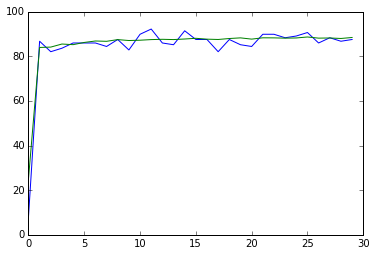

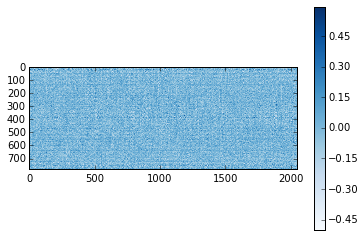

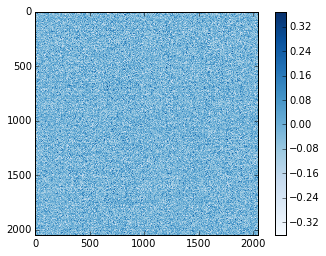

In [162]:
plt.plot(training_hist)
plt.plot(validation_hist)
plt.show()



plt.imshow(w1, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

plt.imshow(w2, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

element 0


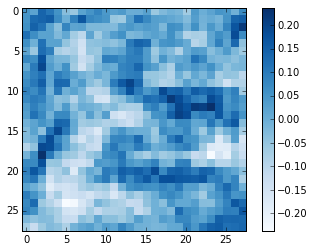

element 4


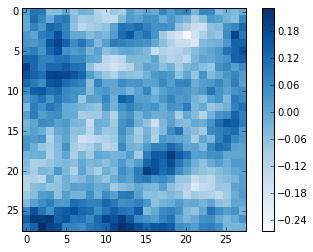

element 8


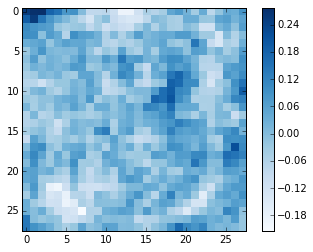

element 12


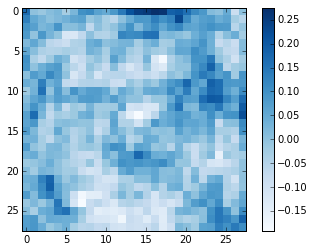

element 16


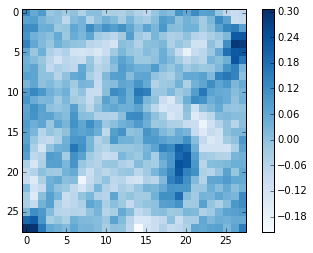

element 20


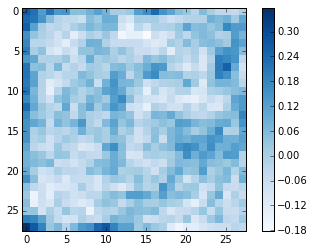

element 24


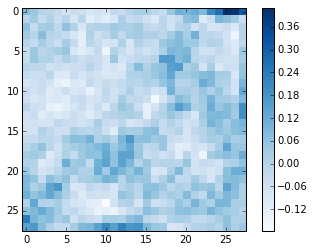

element 28


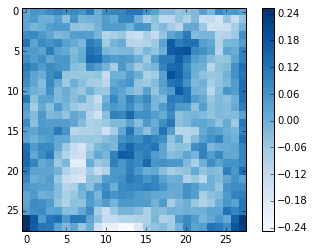

element 32


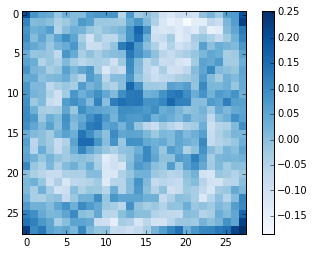

element 36


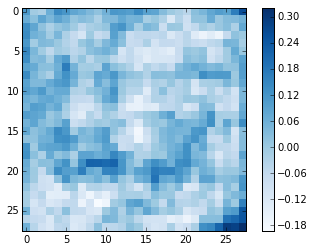

element 40


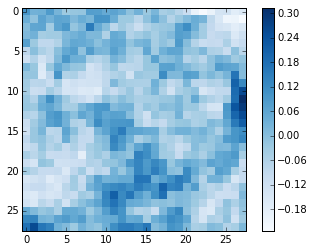

element 44


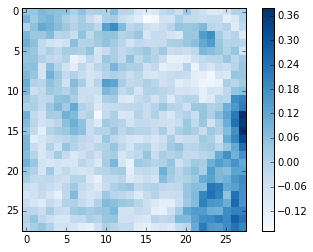

element 48


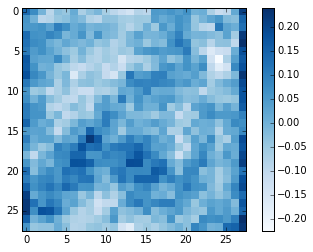

element 52


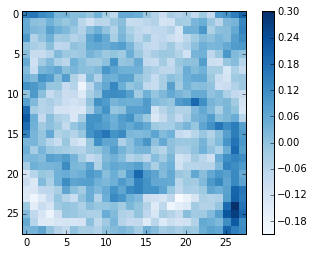

element 56


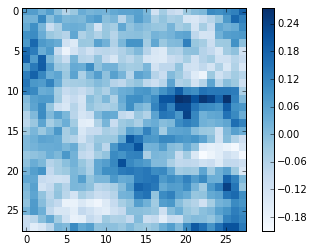

element 60


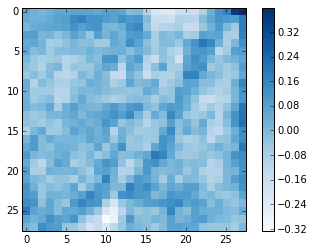

element 64


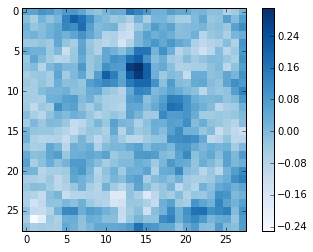

element 68


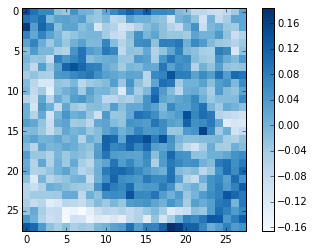

element 72


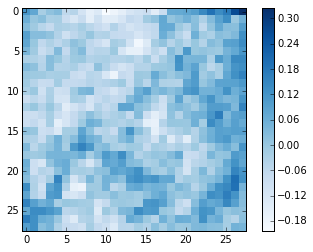

element 76


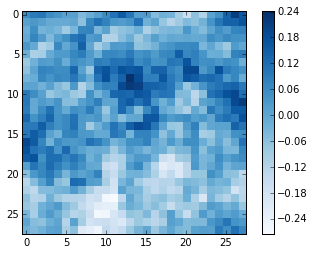

element 80


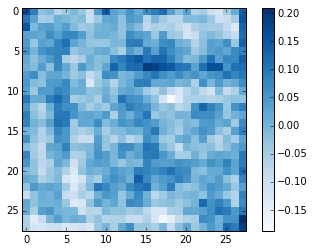

element 84


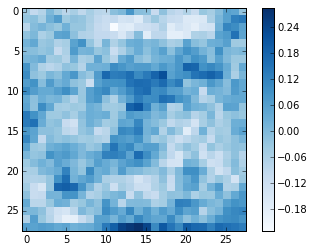

element 88


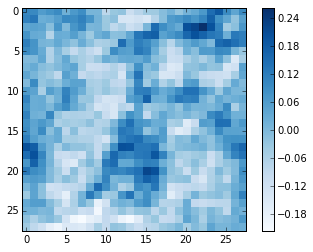

element 92


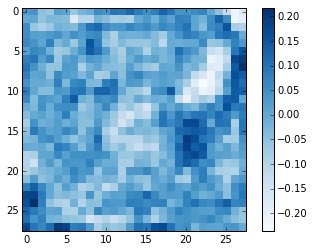

element 96


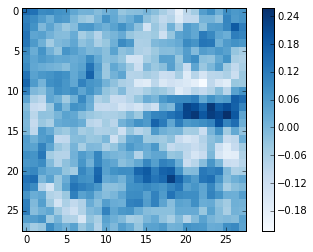

element 100


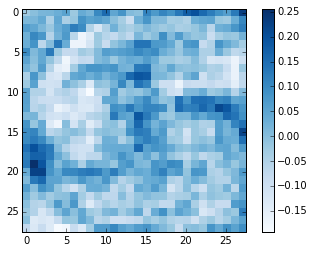

element 104


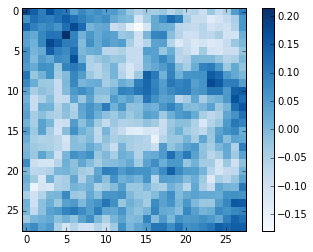

element 108


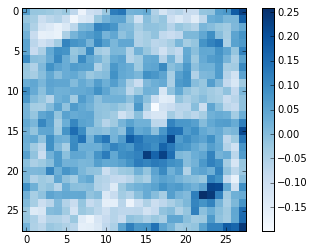

element 112


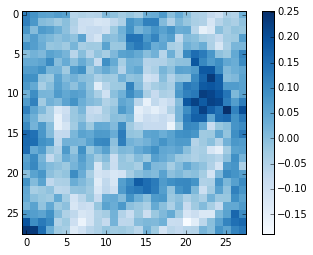

element 116


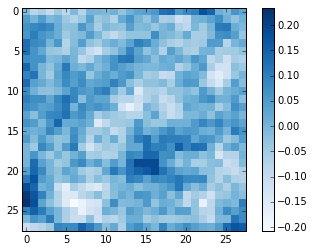

element 120


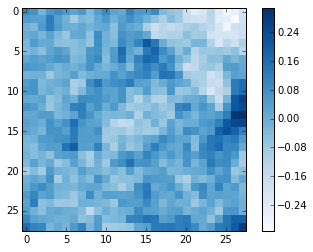

element 124


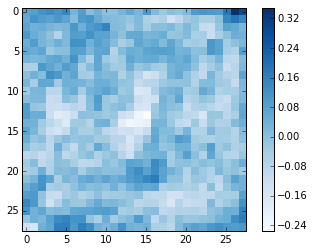

element 128


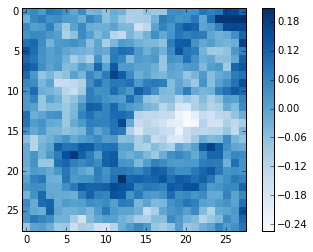

element 132


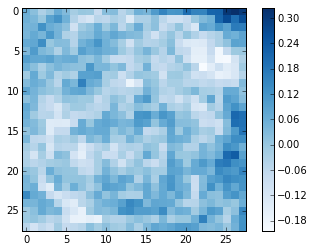

element 136


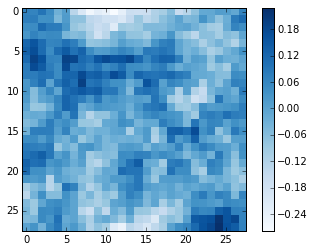

element 140


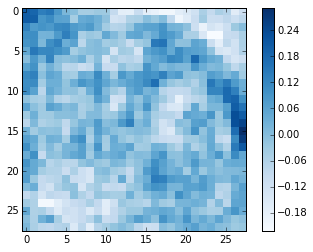

element 144


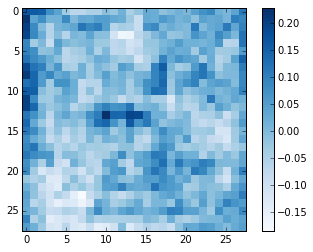

element 148


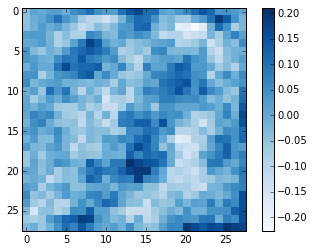

element 152


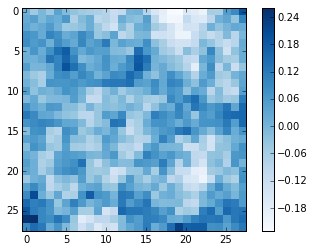

element 156


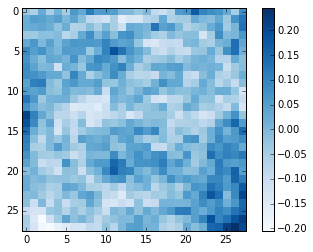

element 160


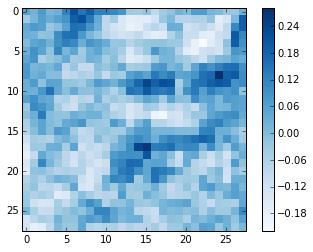

element 164


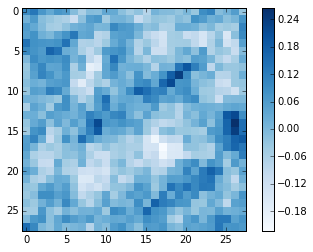

element 168


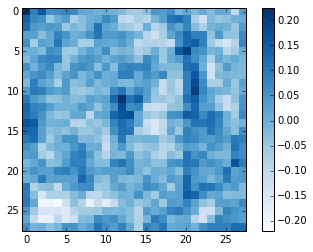

element 172


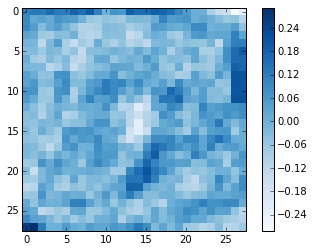

element 176


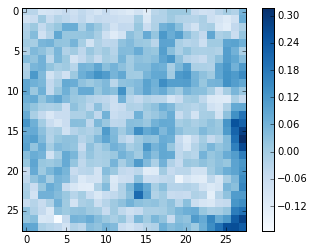

element 180


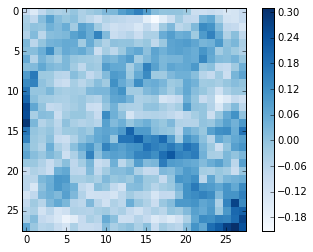

element 184


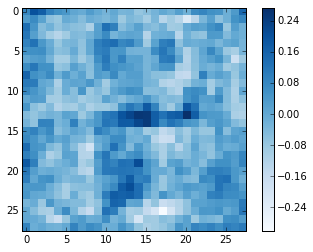

element 188


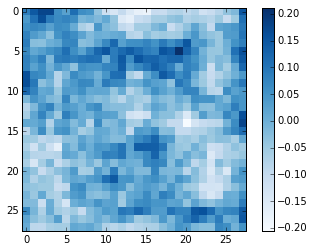

element 192


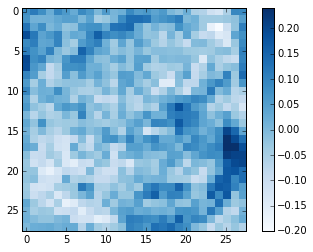

element 196


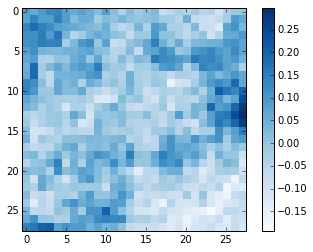

element 200


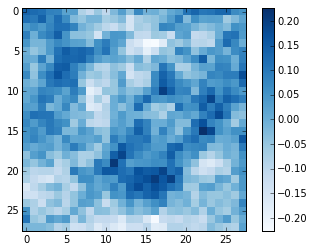

element 204


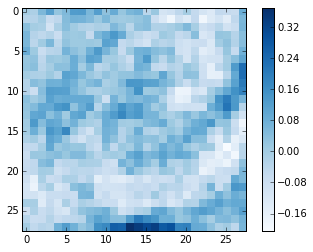

element 208


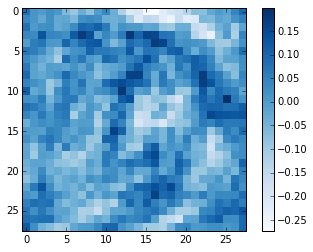

element 212


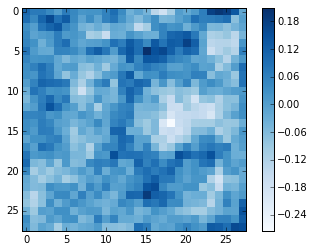

element 216


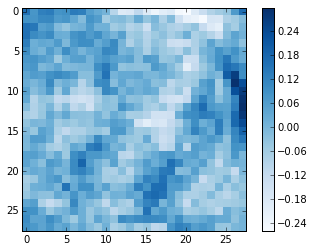

element 220


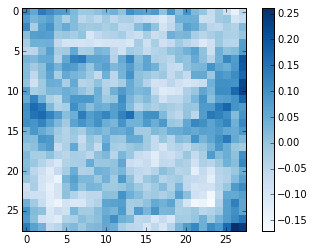

element 224


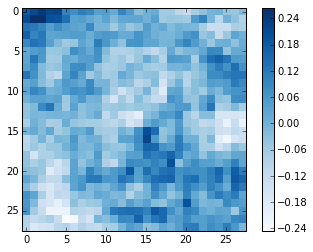

element 228


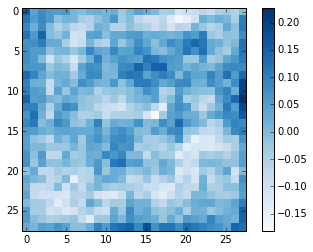

element 232


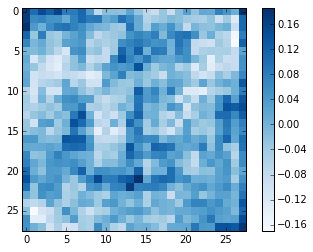

element 236


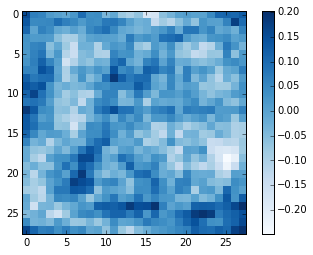

element 240


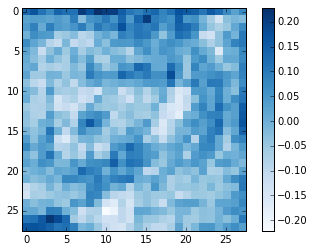

element 244


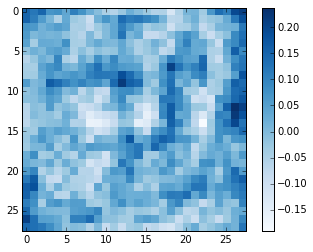

element 248


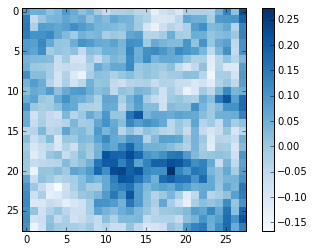

element 252


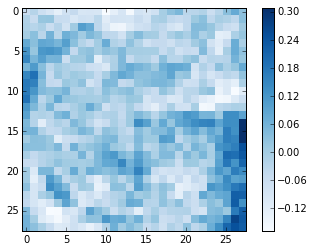

element 256


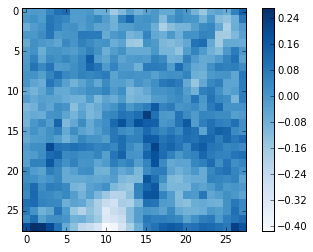

element 260


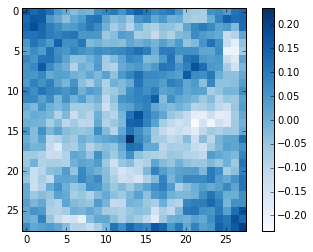

element 264


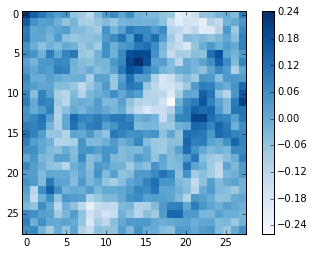

element 268


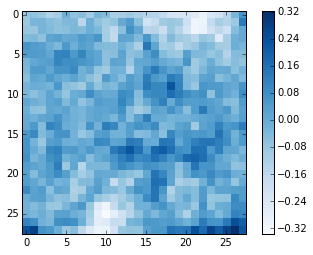

element 272


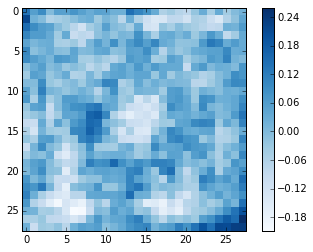

element 276


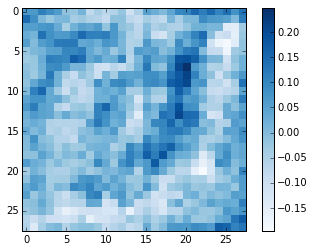

element 280


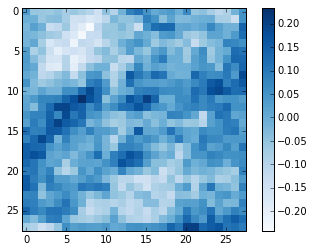

element 284


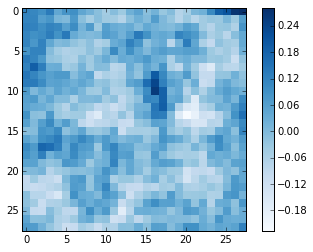

element 288


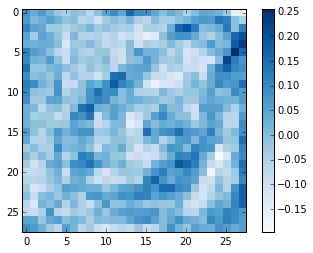

element 292


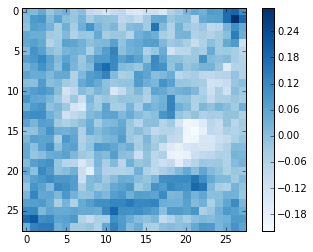

element 296


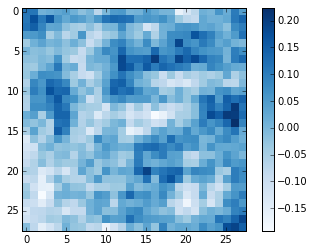

element 300


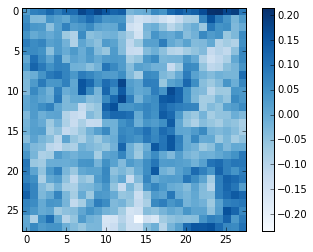

element 304


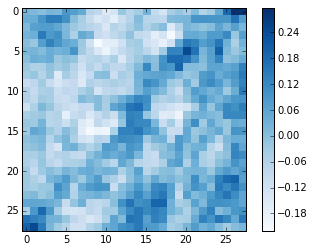

element 308


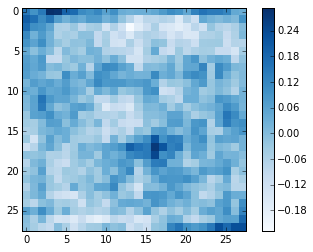

element 312


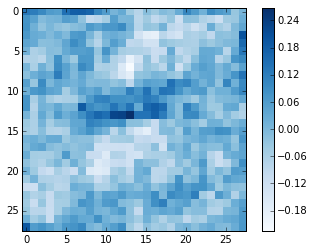

element 316


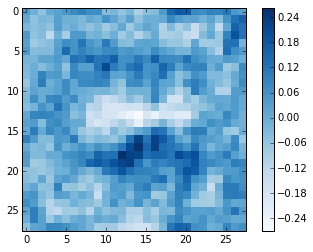

element 320


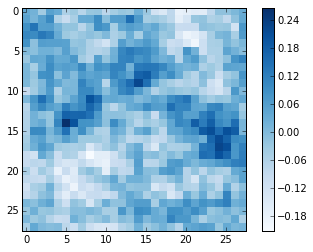

element 324


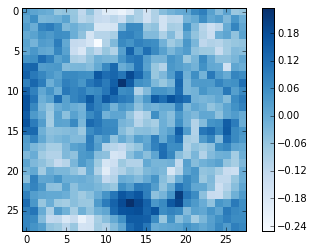

element 328


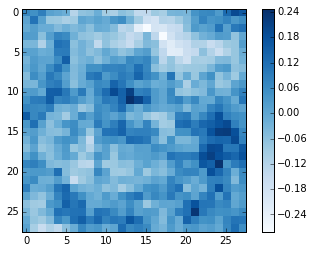

element 332


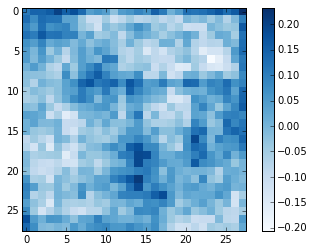

element 336


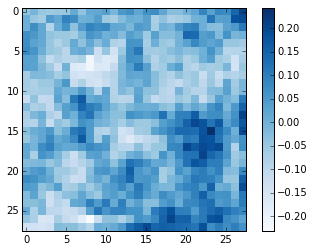

element 340


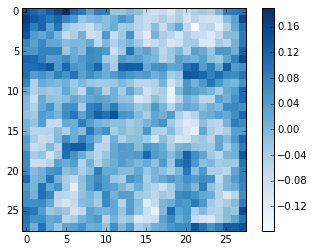

element 344


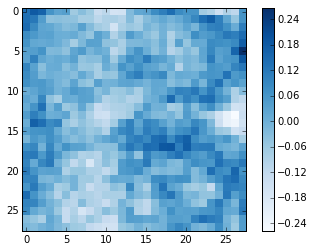

element 348


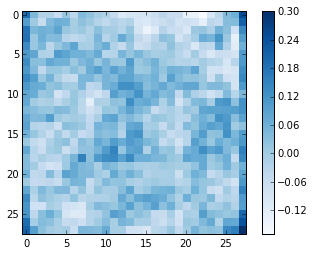

element 352


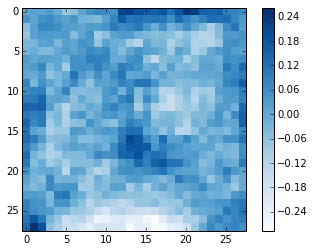

element 356


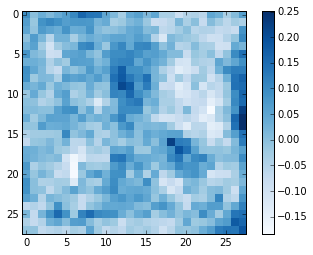

element 360


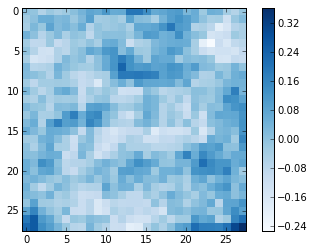

element 364


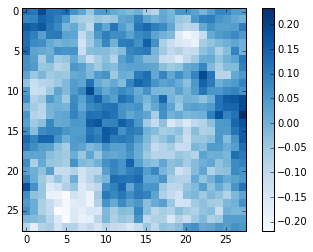

element 368


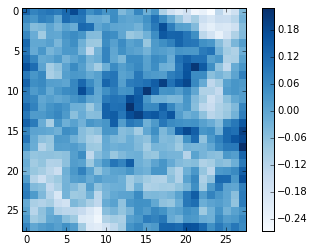

element 372


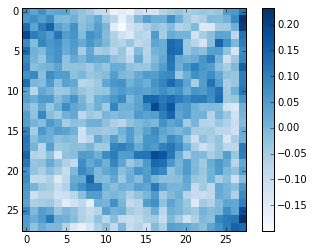

element 376


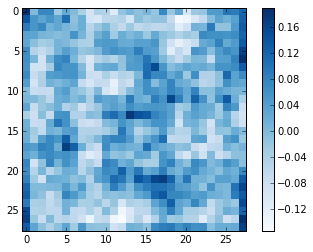

element 380


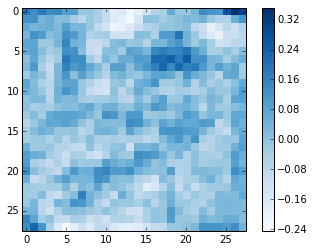

element 384


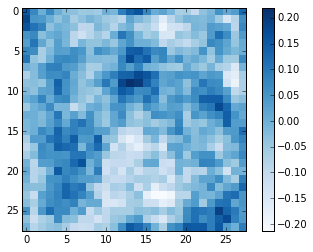

element 388


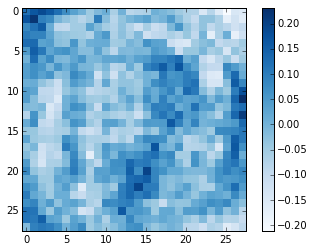

element 392


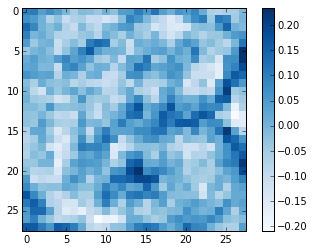

element 396


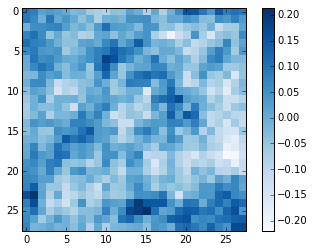

element 400


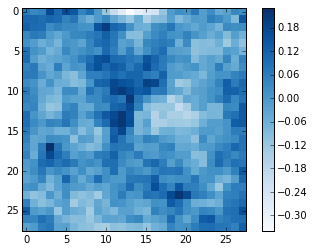

element 404


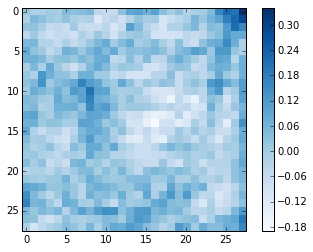

element 408


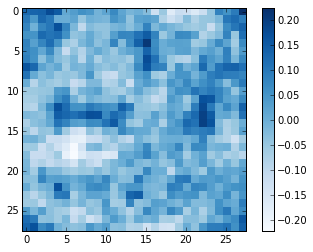

element 412


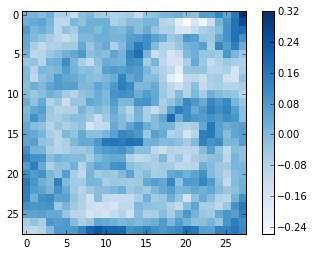

element 416


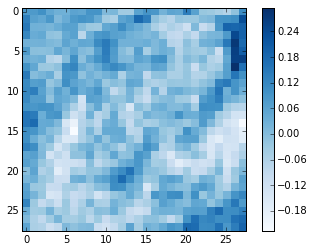

element 420


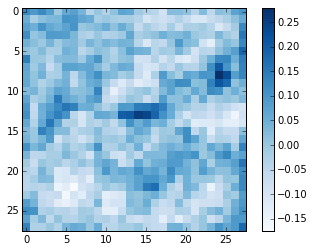

element 424


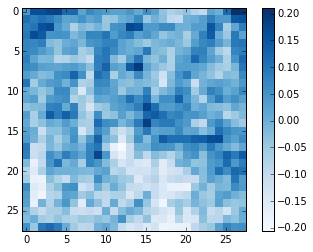

element 428


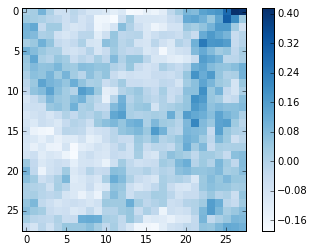

element 432


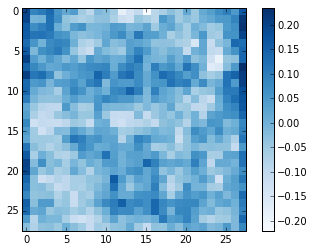

element 436


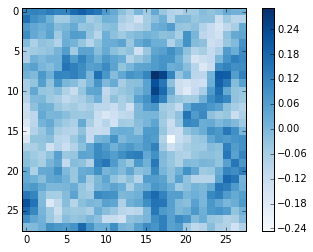

element 440


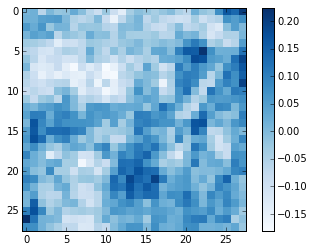

element 444


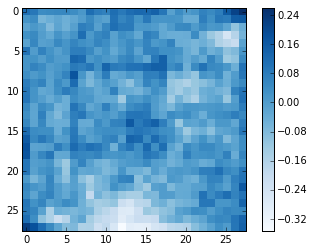

element 448


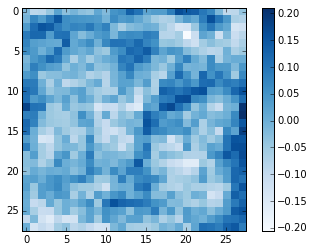

element 452


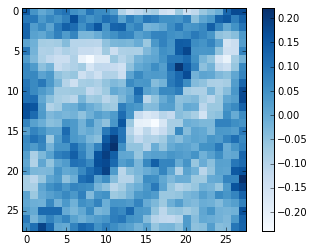

element 456


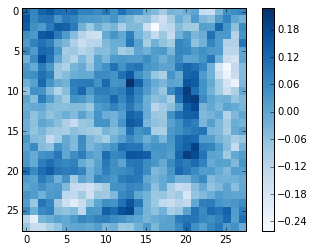

element 460


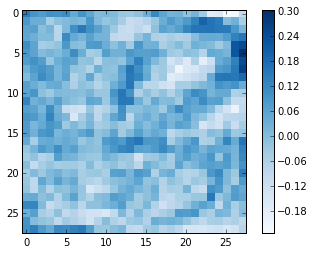

element 464


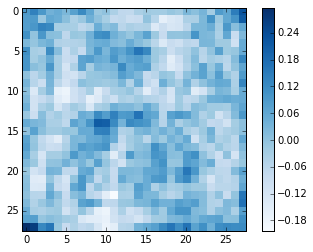

element 468


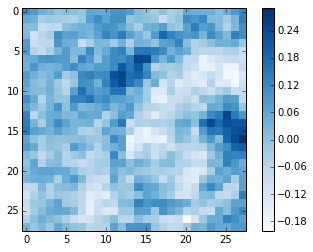

element 472


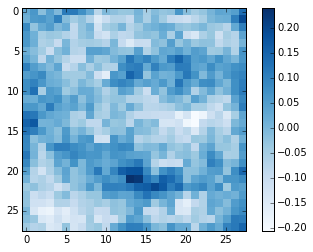

element 476


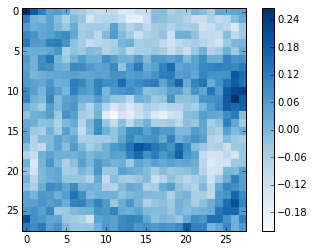

element 480


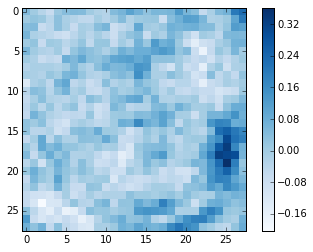

element 484


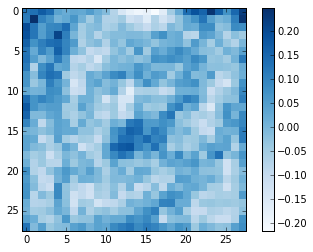

element 488


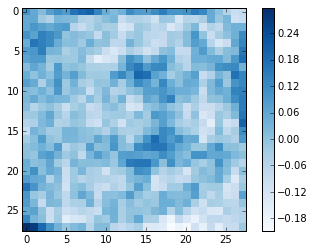

element 492


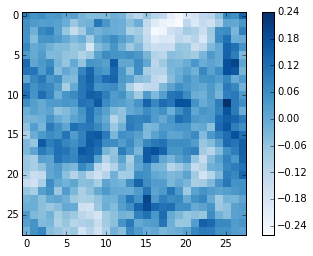

element 496


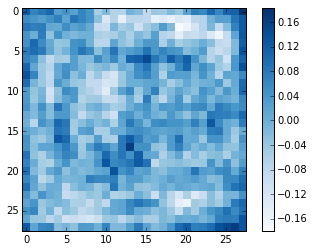

element 500


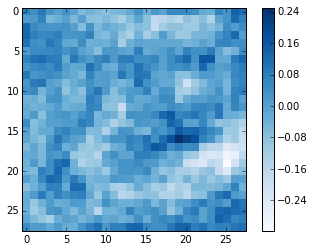

element 504


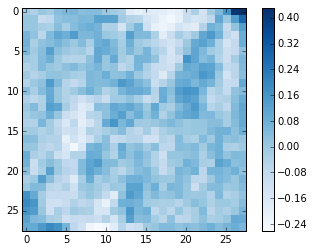

element 508


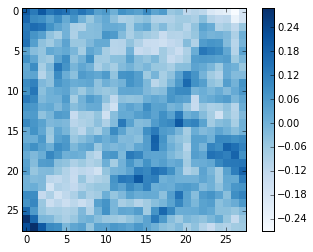

element 512


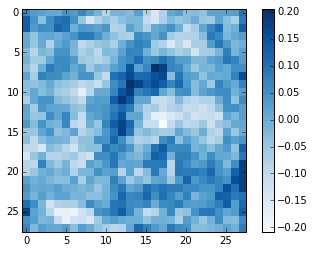

element 516


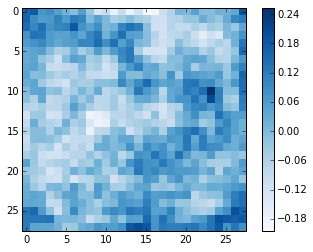

element 520


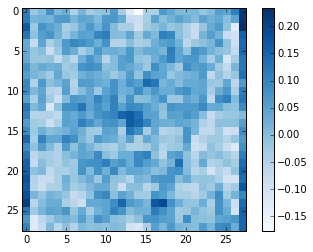

element 524


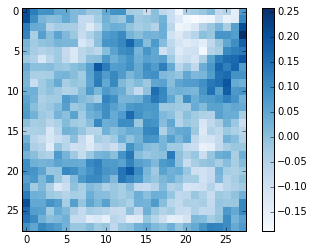

element 528


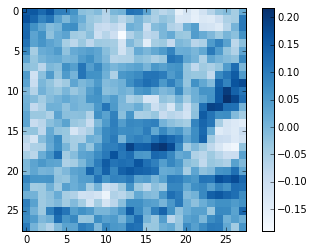

element 532


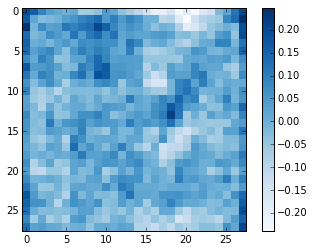

element 536


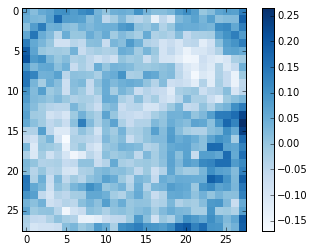

element 540


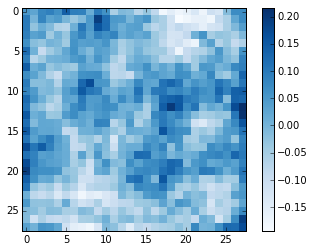

element 544


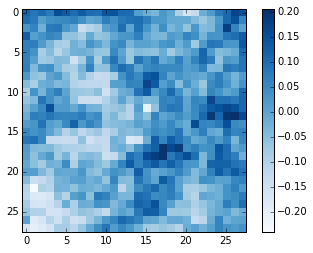

element 548


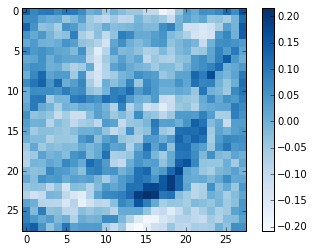

element 552


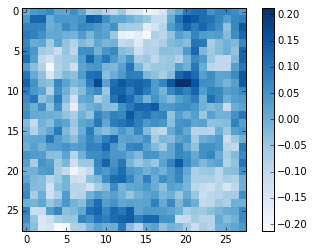

element 556


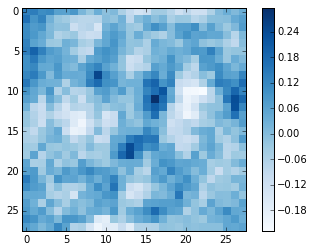

element 560


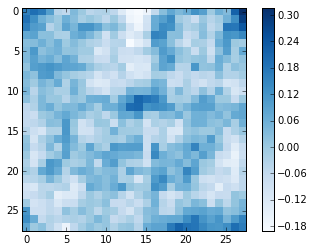

element 564


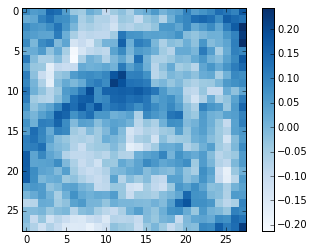

element 568


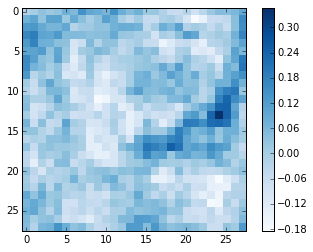

element 572


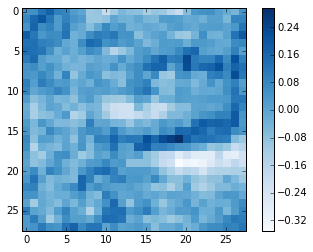

element 576


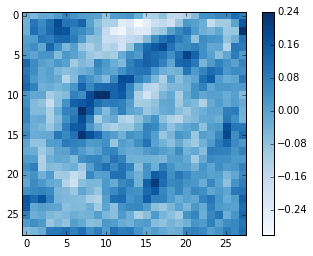

element 580


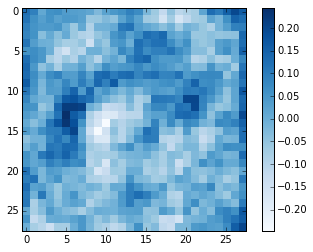

element 584


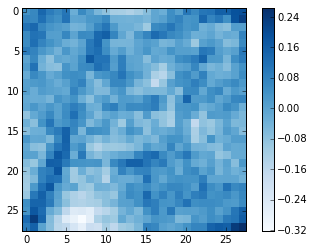

element 588


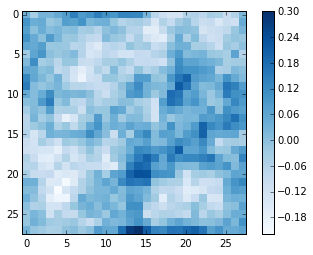

element 592


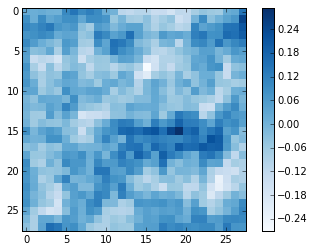

element 596


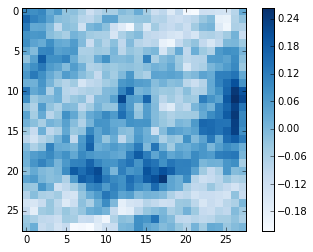

element 600


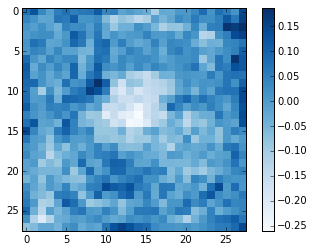

element 604


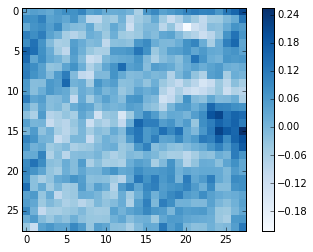

element 608


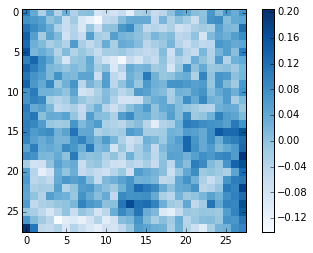

element 612


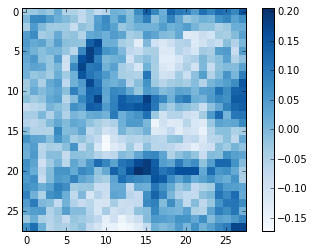

element 616


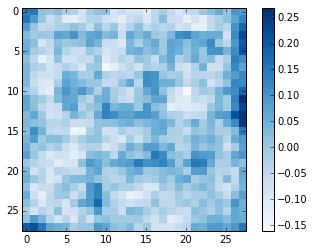

element 620


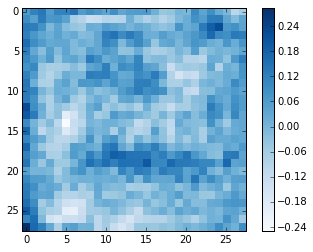

element 624


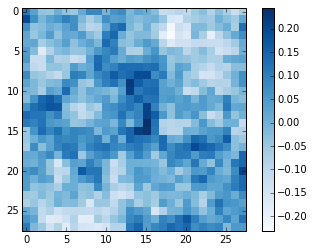

element 628


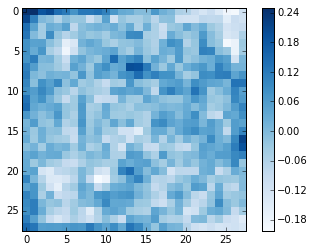

element 632


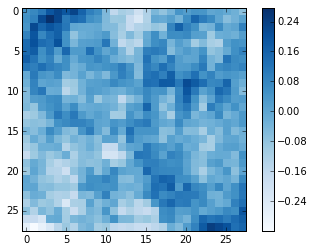

element 636


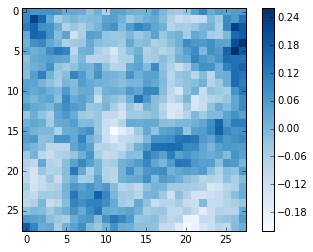

element 640


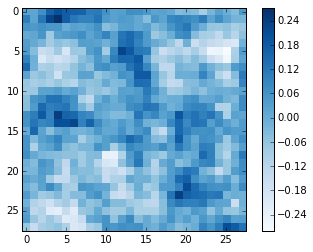

element 644


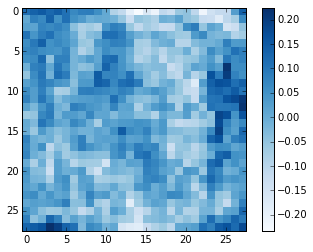

element 648


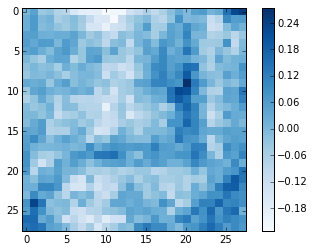

element 652


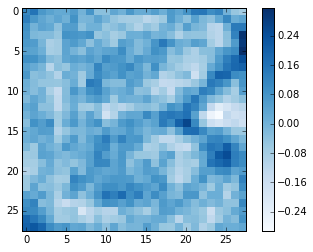

element 656


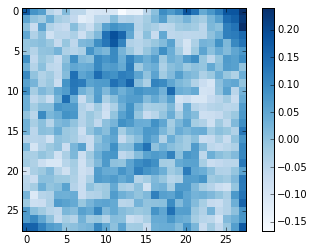

element 660


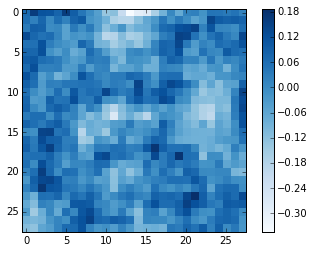

element 664


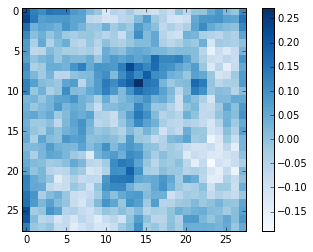

element 668


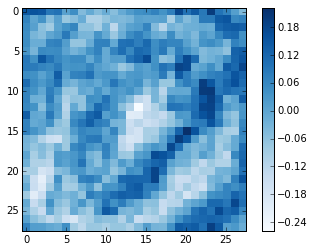

element 672


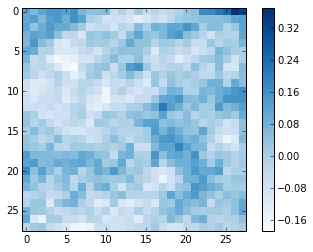

element 676


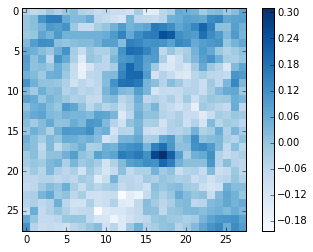

element 680


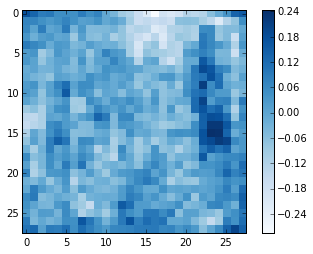

element 684


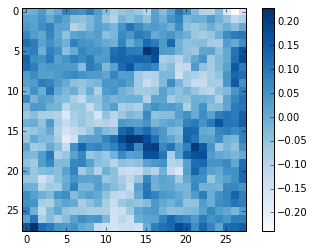

element 688


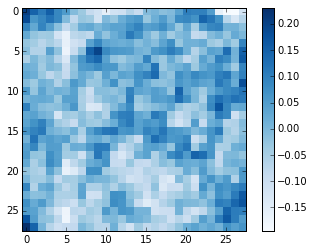

element 692


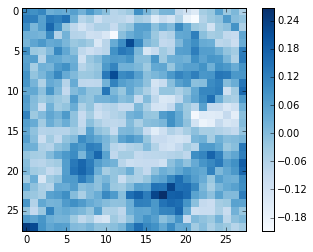

element 696


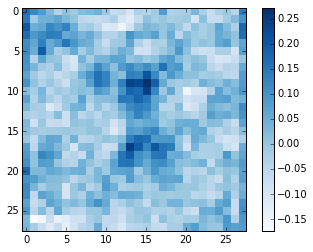

element 700


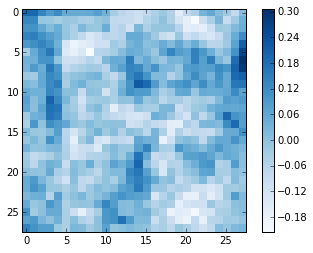

element 704


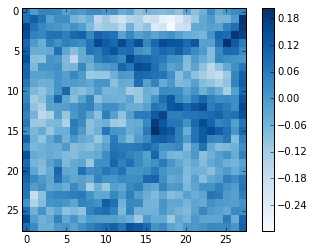

element 708


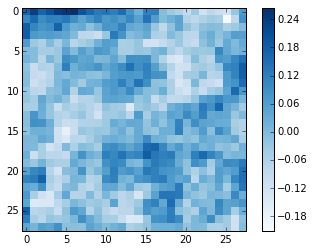

element 712


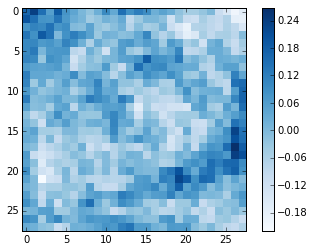

element 716


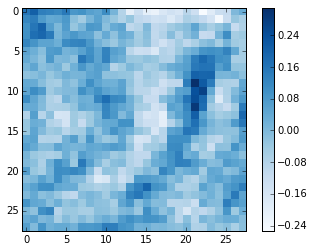

element 720


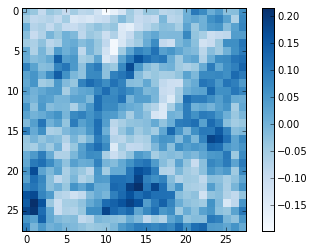

element 724


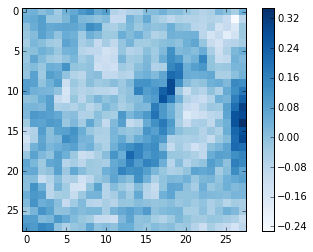

element 728


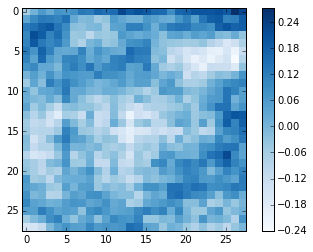

element 732


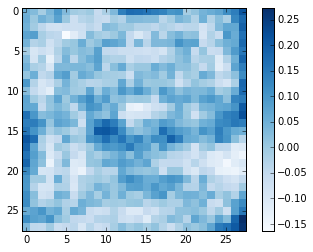

element 736


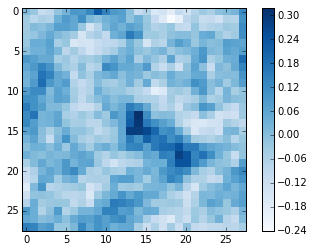

element 740


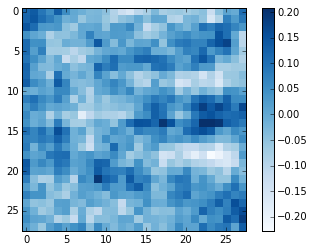

element 744


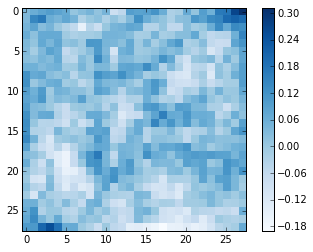

element 748


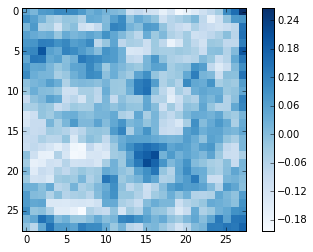

element 752


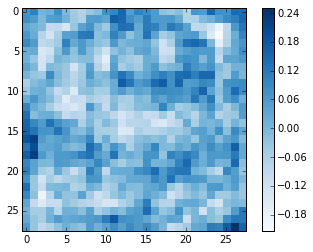

element 756


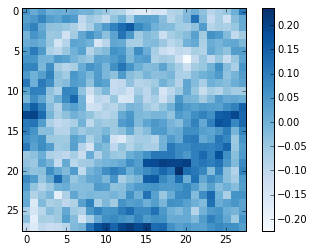

element 760


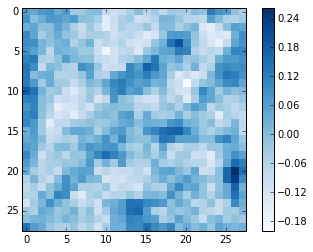

element 764


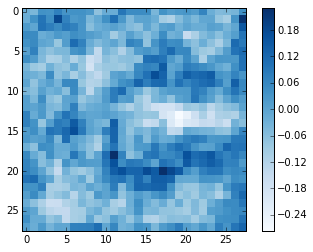

element 768


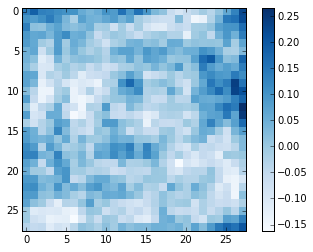

element 772


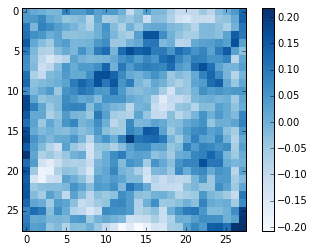

element 776


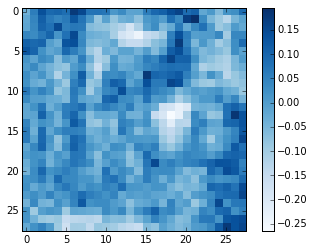

element 780


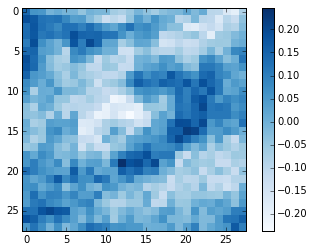

element 784


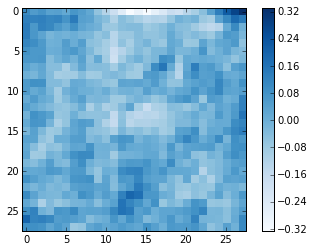

element 788


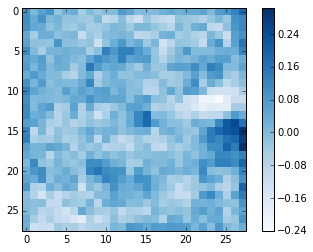

element 792


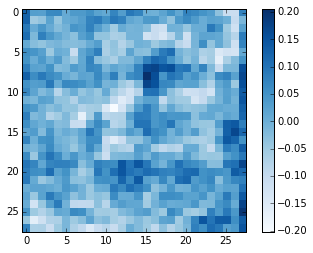

element 796


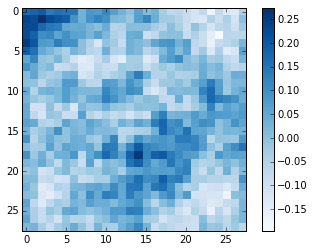

element 800


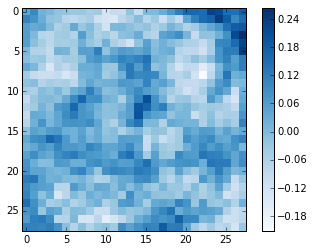

element 804


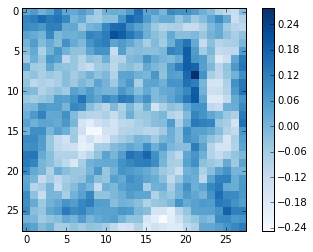

element 808


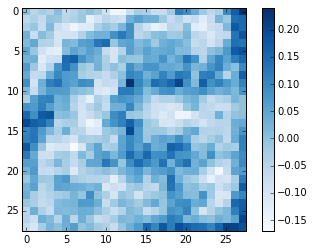

element 812


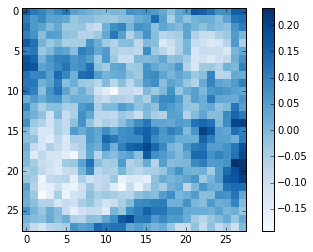

element 816


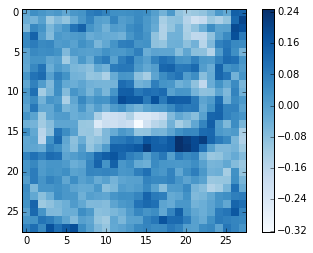

element 820


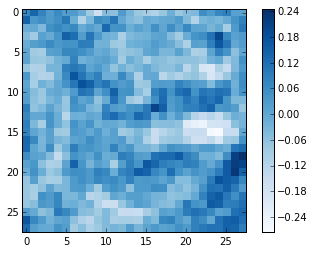

element 824


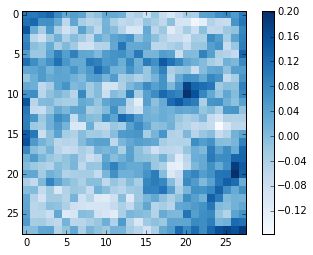

element 828


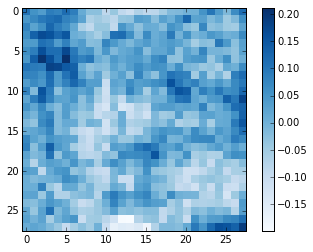

element 832


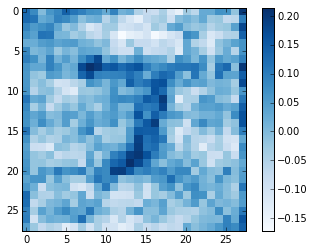

element 836


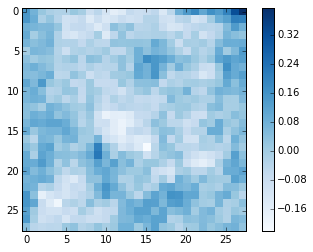

element 840


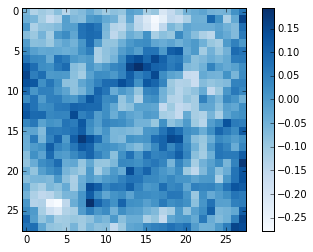

element 844


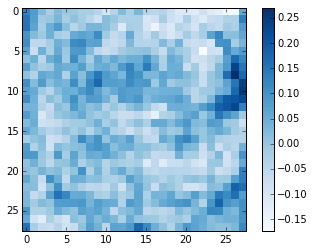

element 848


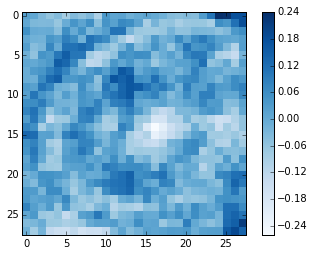

element 852


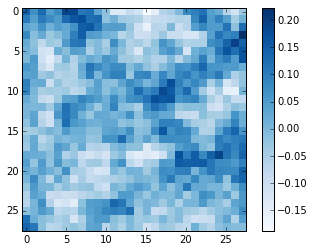

element 856


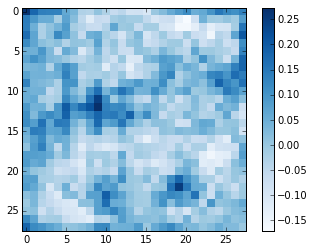

element 860


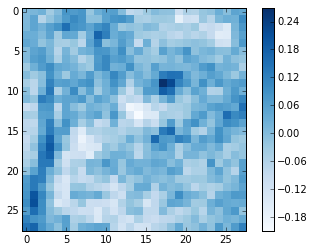

element 864


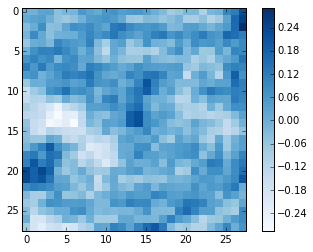

element 868


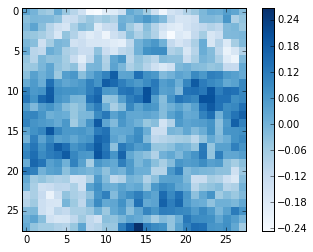

element 872


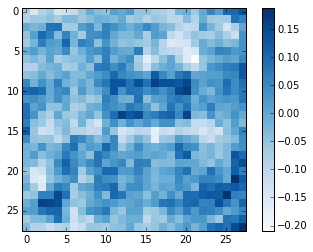

element 876


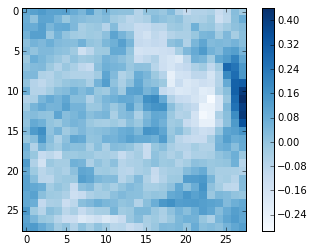

element 880


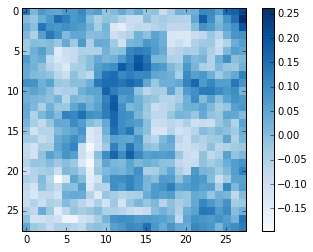

element 884


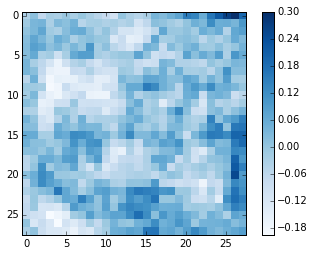

element 888


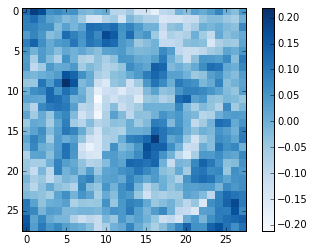

element 892


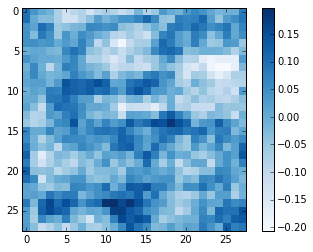

element 896


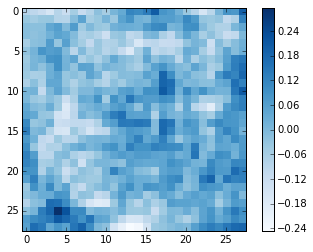

element 900


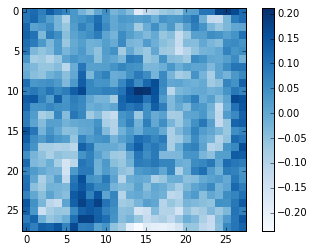

element 904


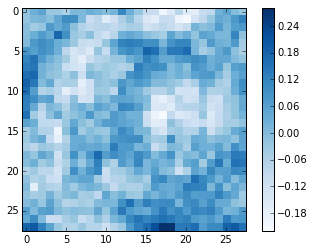

element 908


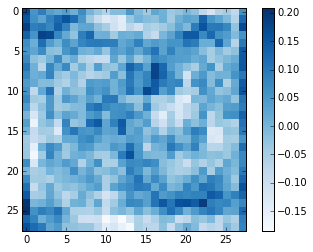

element 912


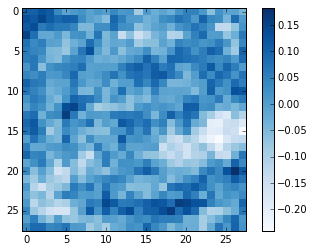

element 916


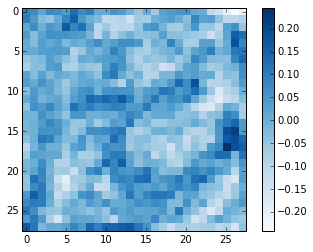

element 920


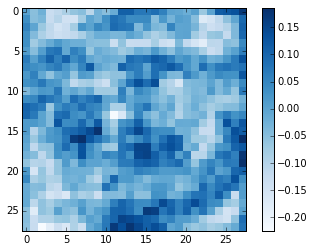

element 924


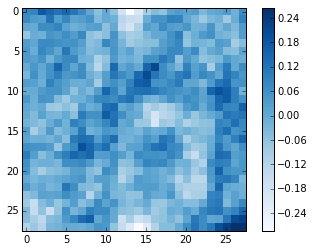

element 928


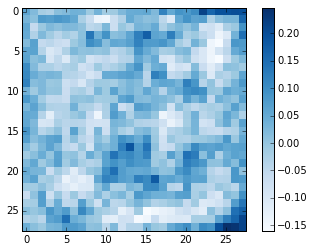

element 932


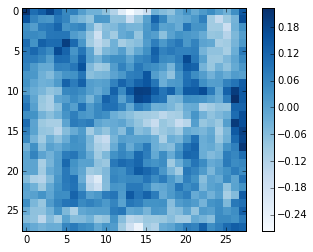

element 936


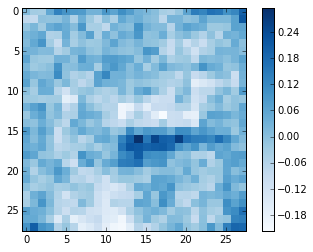

element 940


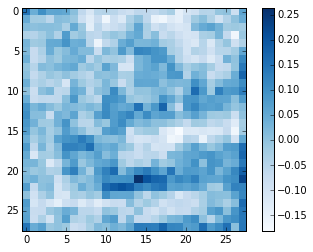

element 944


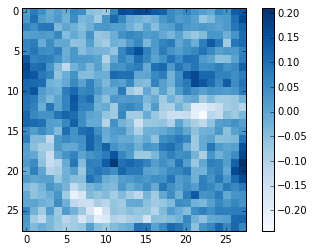

element 948


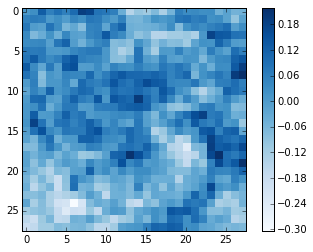

element 952


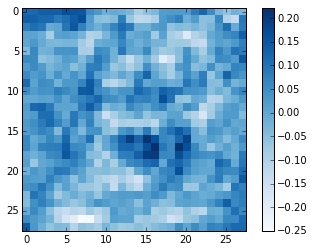

element 956


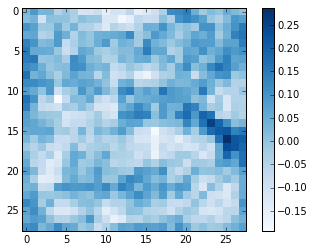

element 960


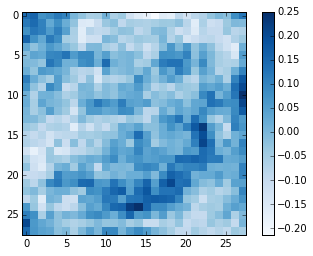

element 964


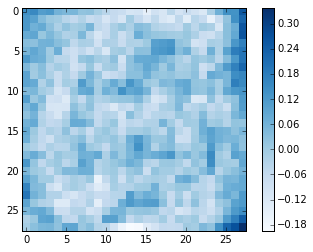

element 968


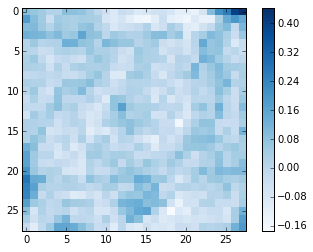

element 972


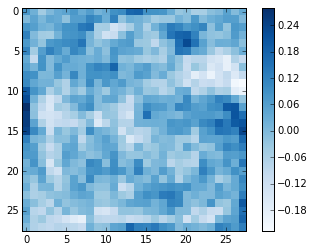

element 976


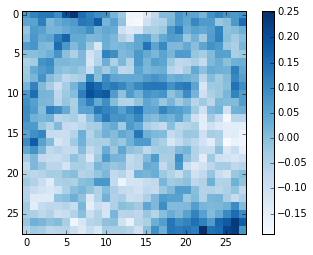

element 980


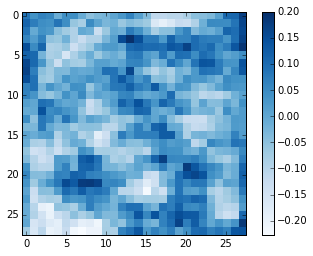

element 984


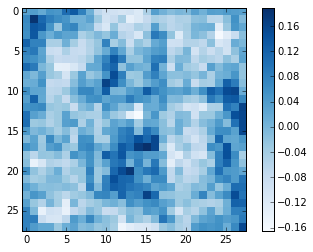

element 988


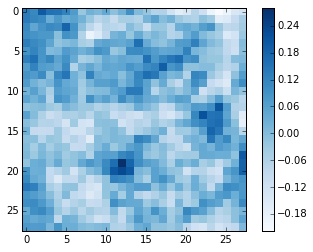

element 992


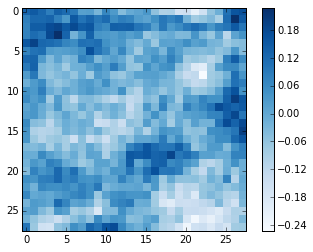

element 996


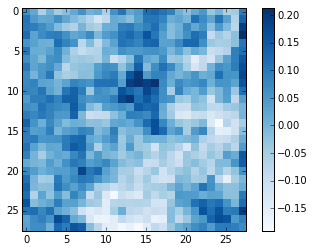

element 1000


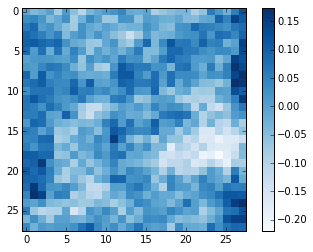

element 1004


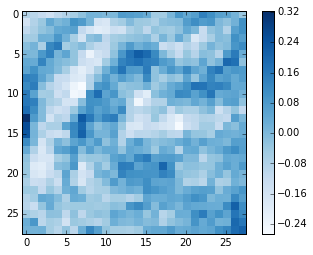

element 1008


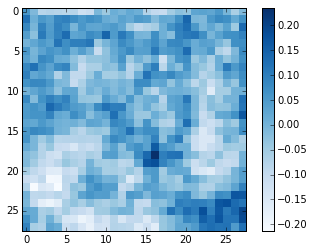

element 1012


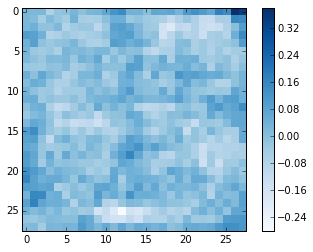

element 1016


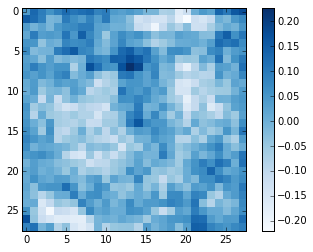

element 1020


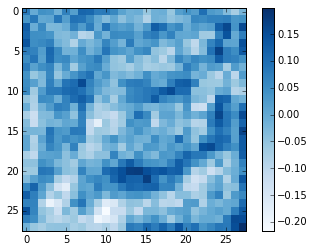

In [163]:
for i in range(0, 1024, 4):
    print 'element', i
    plt.imshow(w1[:, i].reshape(28, 28), interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

In [171]:
# minibatch training with SGD and xavier_initializer
# adding l2_loss

layer_1_size = 1024
layer_2_size = 1024


minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))
    tf_keep_prob = tf.placeholder(tf.float32, name = "tf_keep_prob")
    
    tf_train_dataset_drop = tf.nn.dropout(tf_train_dataset, tf_keep_prob)
    
    w1 = tf.get_variable("w1", shape = (IMG_PIXELS, layer_1_size), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.truncated_normal(shape = [layer_1_size], mean = 0.1, stddev=0.05))
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    h1_drop = tf.nn.dropout(h1, tf_keep_prob)
    
    w2 = tf.get_variable("w2", shape = (layer_1_size, layer_2_size), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.truncated_normal(shape = [layer_2_size], mean = 0.1, stddev=0.05))
    h2 = tf.nn.relu(tf.matmul(h1_drop, w2) + b2)
    h2_drop = tf.nn.dropout(h2, tf_keep_prob)
    
    w3 = tf.get_variable("w3", shape = (layer_2_size, NUM_CLASSES), initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.Variable(tf.truncated_normal(shape = [NUM_CLASSES], mean = 0.1, stddev=0.05))
    logits = tf.matmul(h2_drop, w3) + b3
    
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)
                + sum([0.00001*tf.nn.l2_loss(var) for var in [w1, b1, w2, b2, w3, b3]])
    ) 
    opt = tf.train.AdamOptimizer().minimize(loss)
    predictions = tf.nn.softmax(logits)

training_hist,  validation_hist, loss_hist, [w1, w2] = train_funciton(minibatch_graph, 
                                                            (train_dataset, train_labels), 
                                                            (val_dataset, val_labels), 
                                                            (test_dataset, test_labels), 
                                                            training_steps = 10000,
                                                            keep_prob=1.0)

Loss at step:  0 2.43858 Train Acc 14.0625 Valid Acc 40.89
Elapsed Time 1.64572811127
Loss at step:  250 0.427628 Train Acc 86.71875 Valid Acc 84.62
Elapsed Time 15.7434570789
Loss at step:  500 0.561004 Train Acc 82.8125 Valid Acc 85.69
Elapsed Time 30.1377470493
Loss at step:  750 0.466483 Train Acc 88.28125 Valid Acc 86.43
Elapsed Time 44.1859281063
Loss at step:  1000 0.435733 Train Acc 89.84375 Valid Acc 87.73
Elapsed Time 58.1838459969
Loss at step:  1250 0.469467 Train Acc 89.0625 Valid Acc 87.48
Elapsed Time 71.8592891693
Loss at step:  1500 0.338726 Train Acc 92.1875 Valid Acc 88.25
Elapsed Time 88.3859190941
Loss at step:  1750 0.302118 Train Acc 89.0625 Valid Acc 87.92
Elapsed Time 102.891096115
Loss at step:  2000 0.326257 Train Acc 90.625 Valid Acc 88.33
Elapsed Time 116.717895031
Loss at step:  2250 0.332016 Train Acc 89.0625 Valid Acc 88.34
Elapsed Time 130.528100967
Loss at step:  2500 0.320301 Train Acc 89.84375 Valid Acc 88.49
Elapsed Time 144.295665979
Loss at step: 

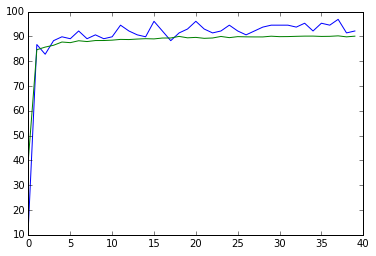

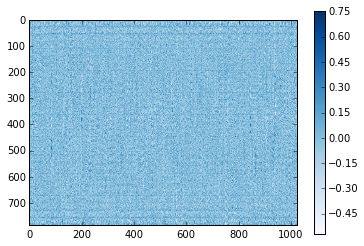

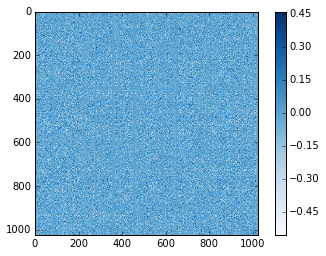

In [172]:
plt.plot(training_hist)
plt.plot(validation_hist)
plt.show()



plt.imshow(w1, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

plt.imshow(w2, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

element 0


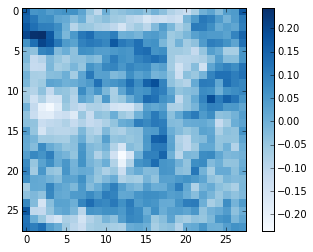

element 4


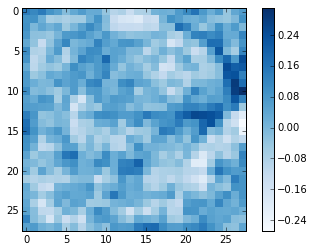

element 8


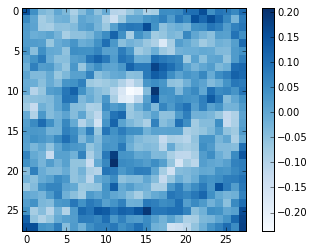

element 12


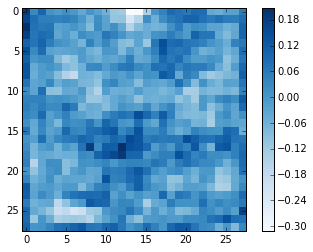

element 16


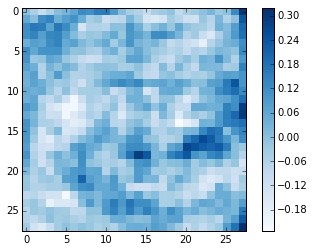

element 20


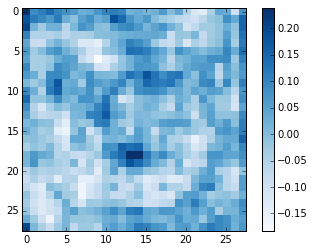

element 24


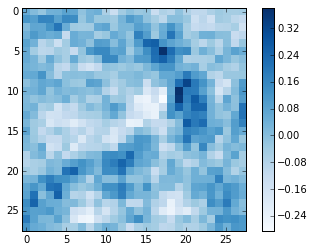

element 28


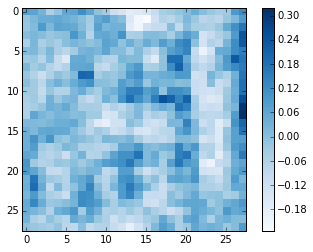

element 32


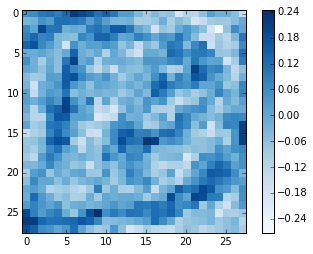

element 36


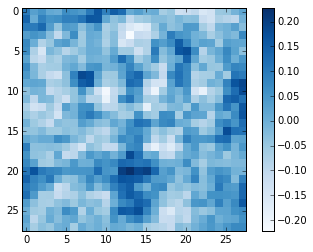

element 40


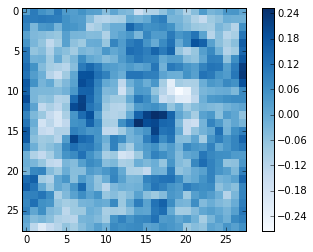

element 44


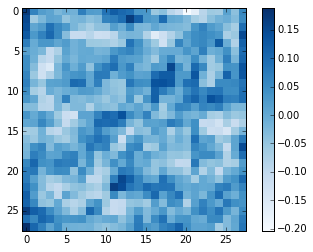

element 48


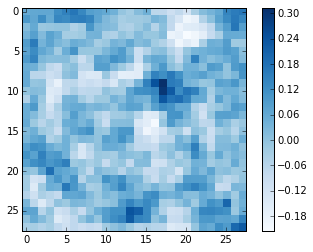

element 52


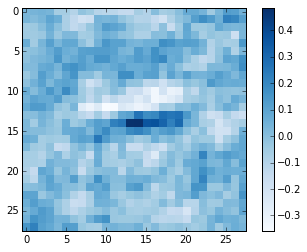

element 56


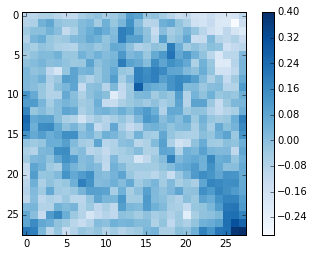

element 60


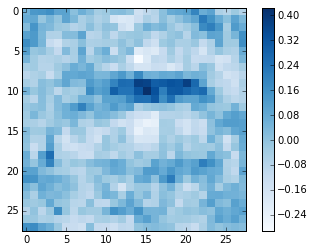

element 64


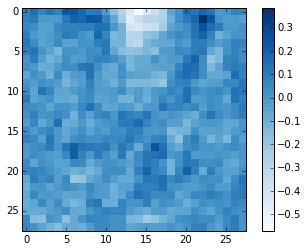

element 68


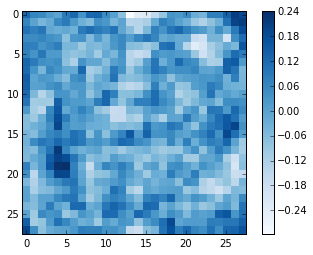

element 72


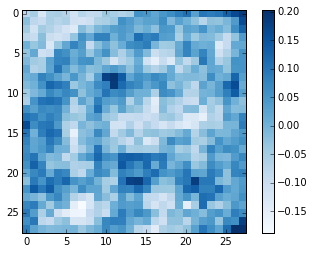

element 76


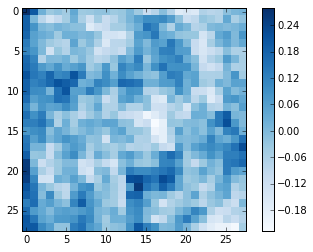

element 80


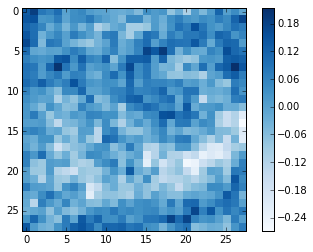

element 84


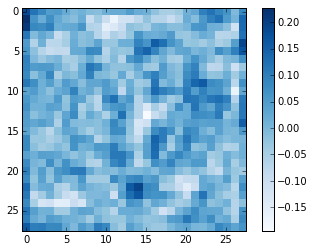

element 88


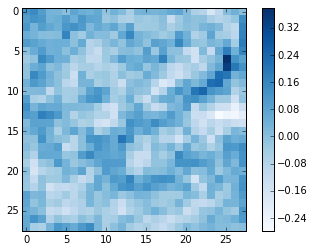

element 92


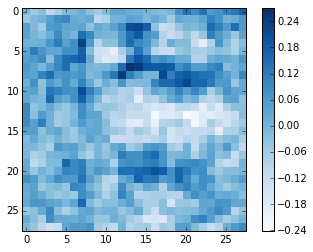

element 96


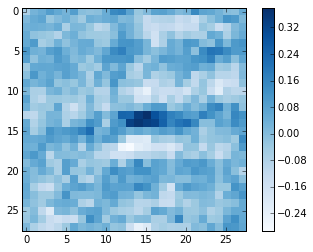

element 100


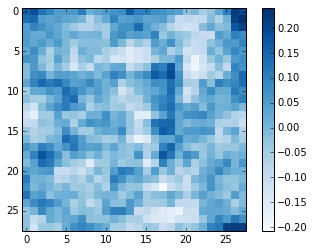

element 104


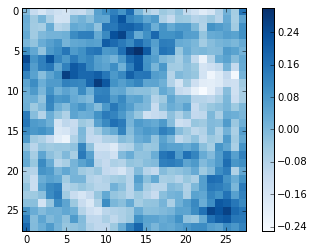

element 108


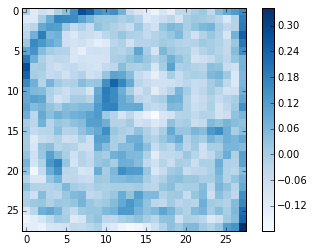

element 112


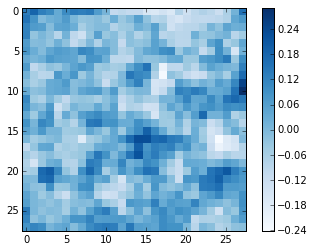

element 116


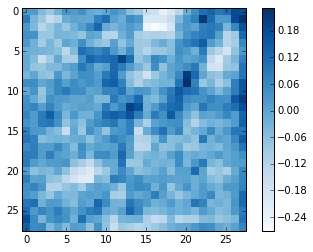

element 120


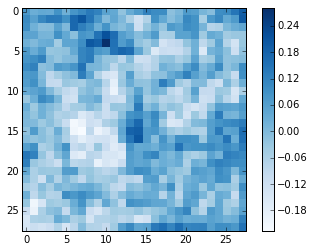

element 124


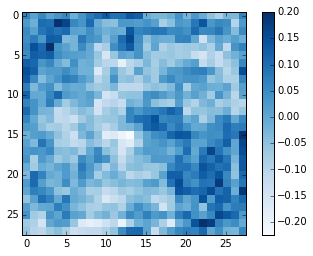

element 128


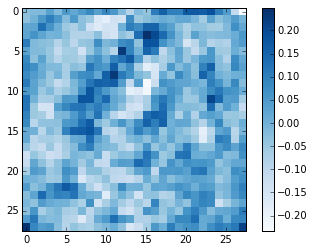

element 132


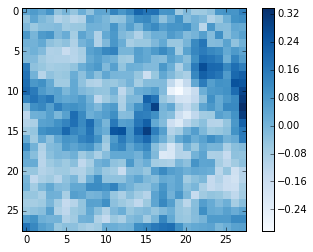

element 136


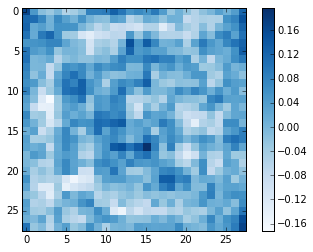

element 140


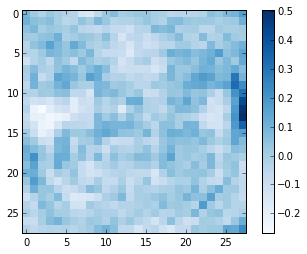

element 144


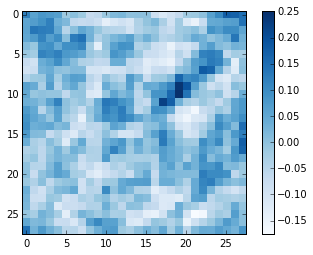

element 148


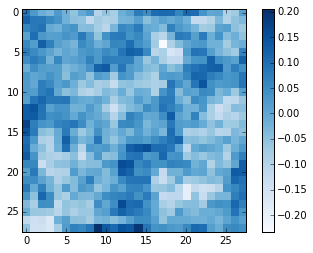

element 152


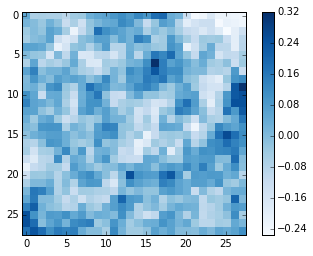

element 156


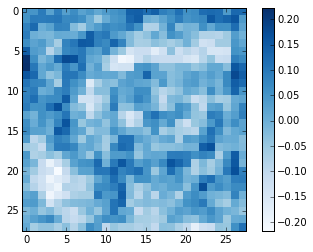

element 160


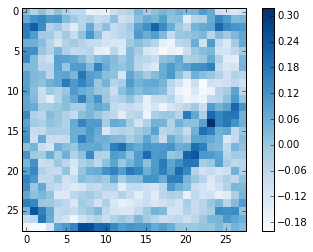

element 164


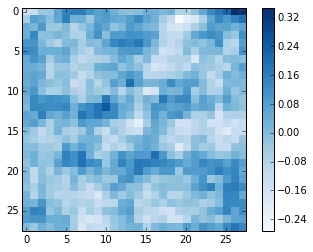

element 168


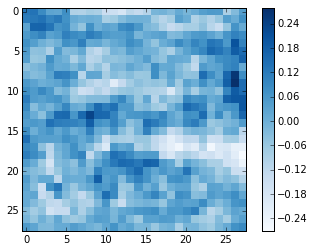

element 172


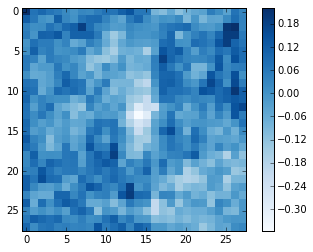

element 176


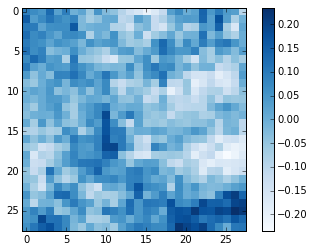

element 180


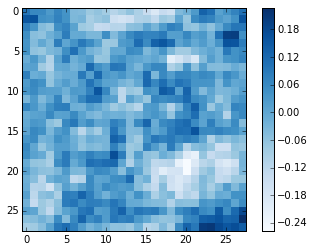

element 184


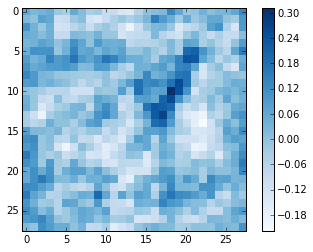

element 188


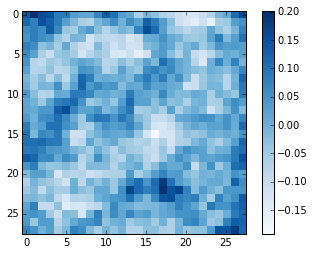

element 192


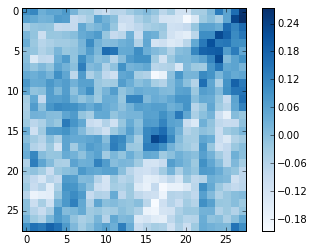

element 196


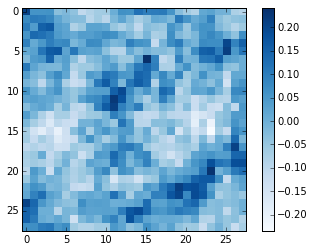

element 200


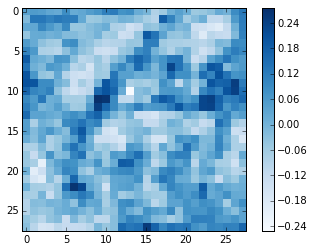

element 204


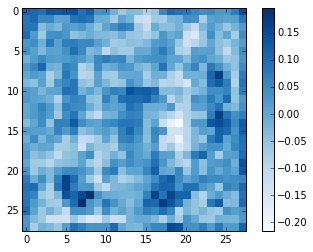

element 208


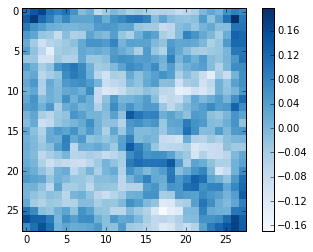

element 212


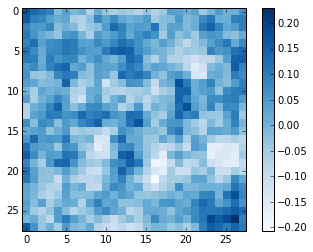

element 216


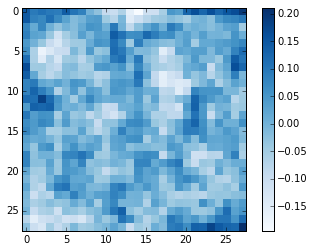

element 220


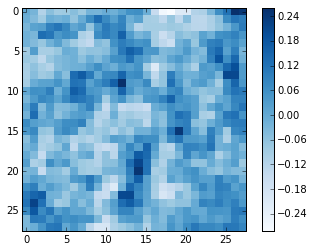

element 224


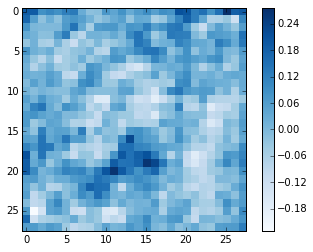

element 228


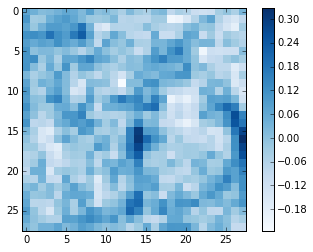

element 232


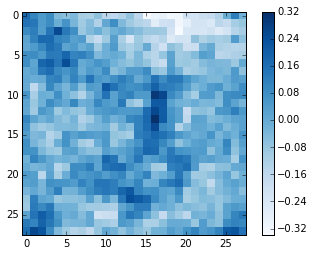

element 236


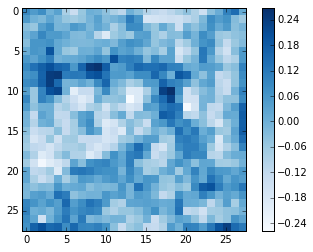

element 240


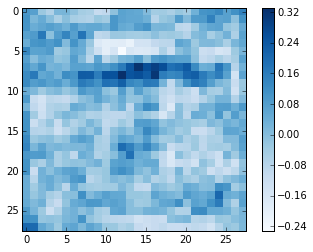

element 244


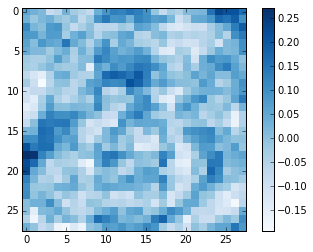

element 248


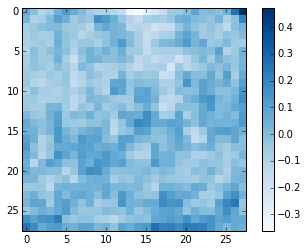

element 252


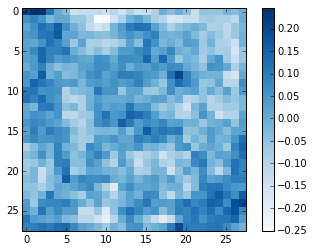

element 256


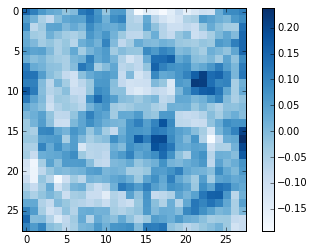

element 260


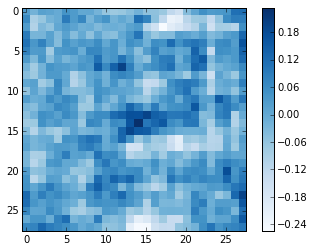

element 264


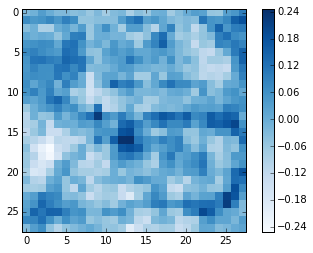

element 268


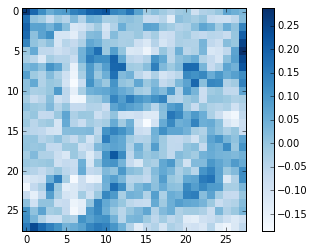

element 272


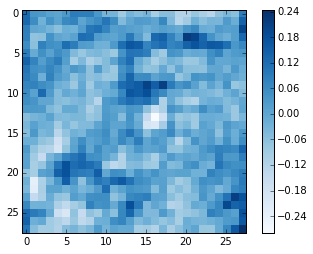

element 276


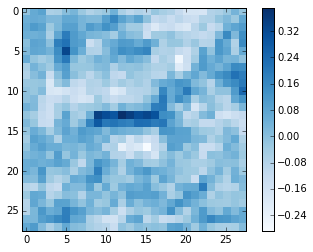

element 280


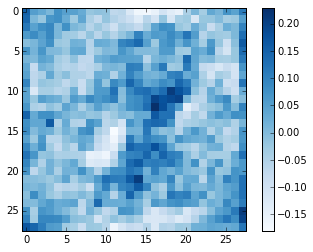

element 284


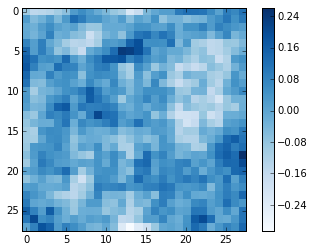

element 288


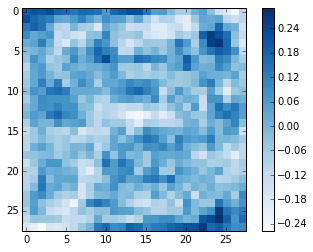

element 292


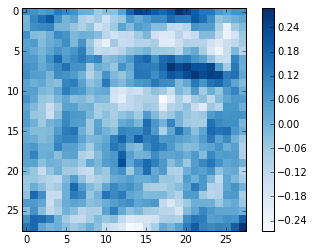

element 296


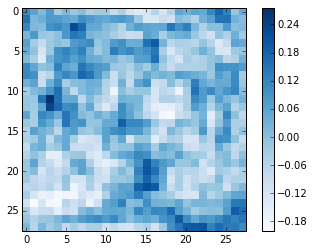

element 300


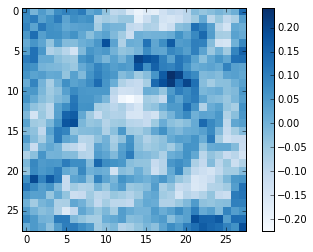

element 304


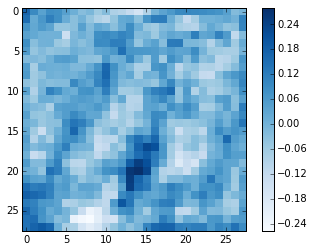

element 308


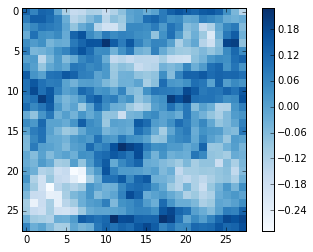

element 312


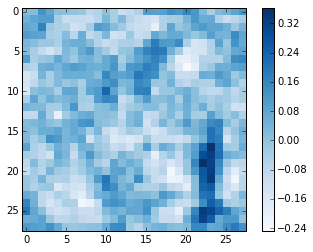

element 316


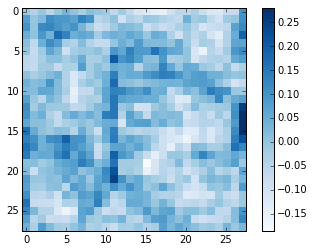

element 320


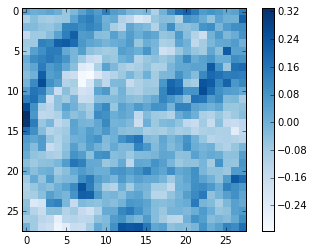

element 324


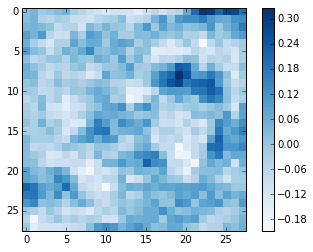

element 328


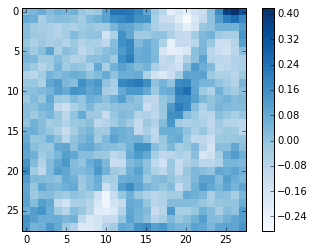

element 332


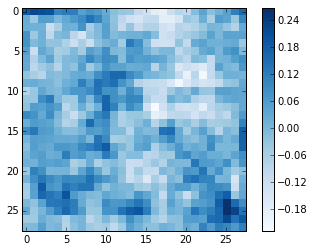

element 336


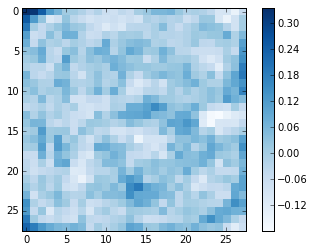

element 340


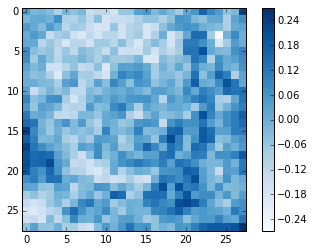

element 344


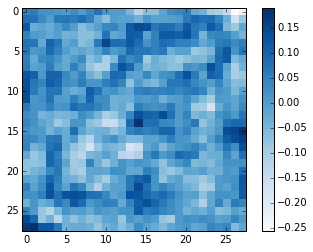

element 348


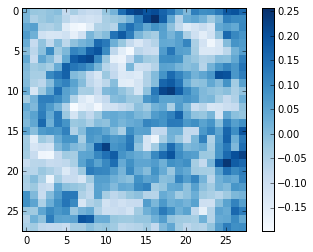

element 352


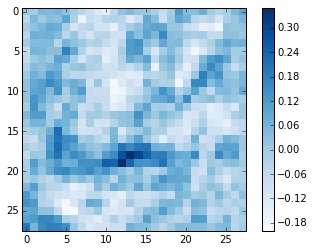

element 356


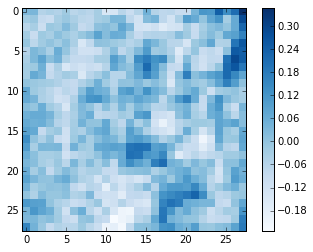

element 360


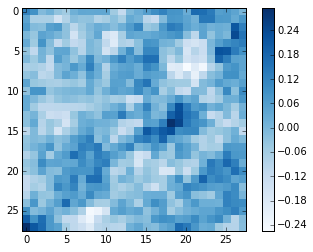

element 364


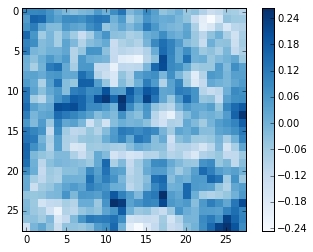

element 368


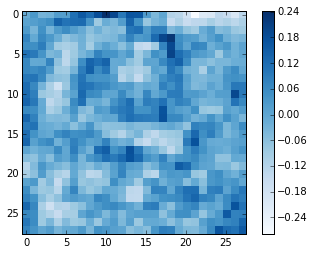

element 372


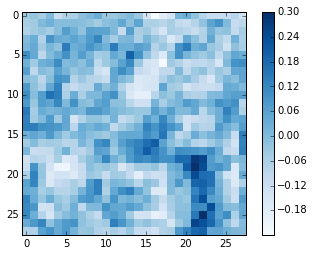

element 376


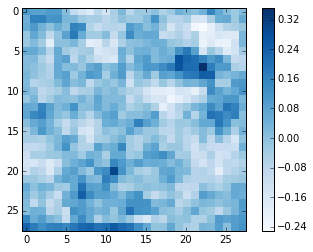

element 380


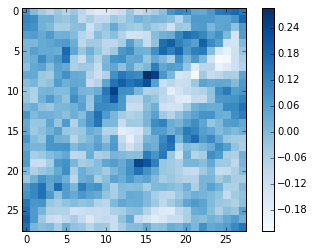

element 384


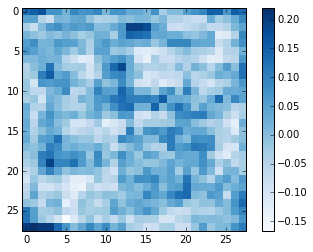

element 388


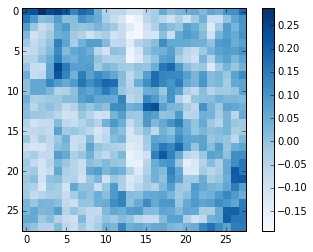

element 392


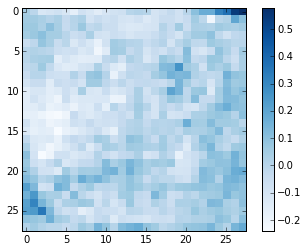

element 396


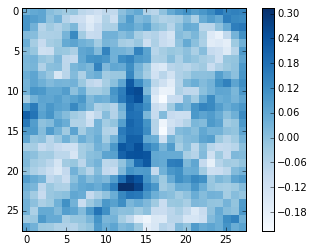

element 400


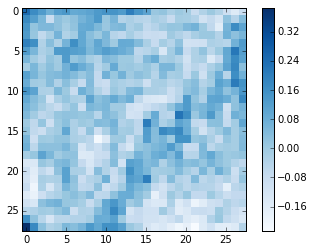

element 404


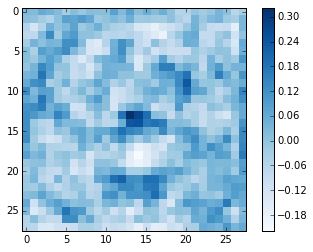

element 408


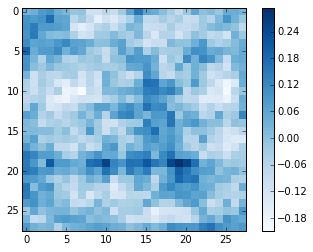

element 412


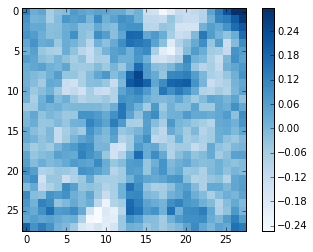

element 416


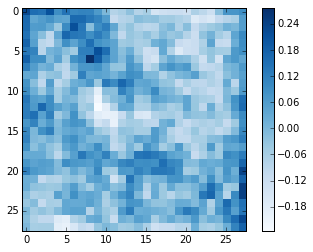

element 420


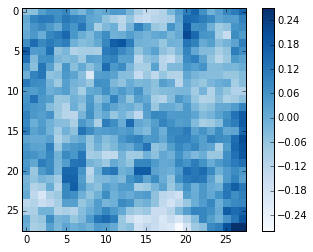

element 424


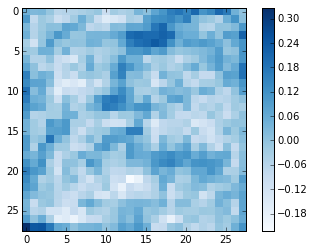

element 428


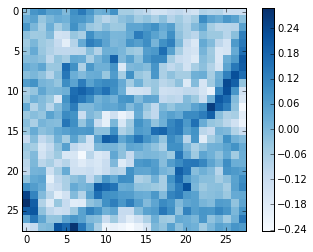

element 432


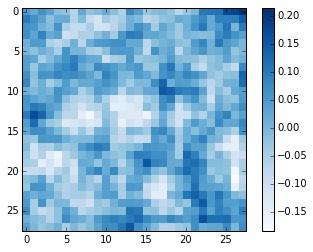

element 436


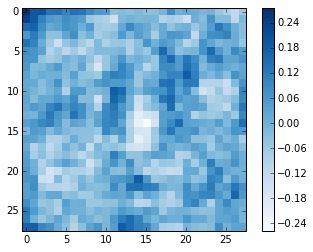

element 440


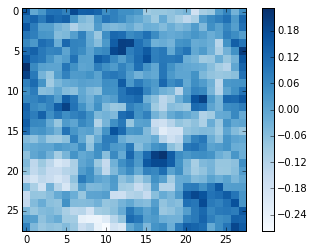

element 444


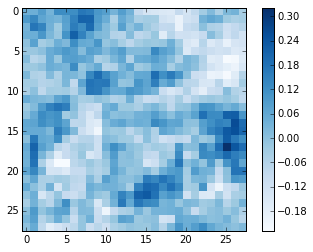

element 448


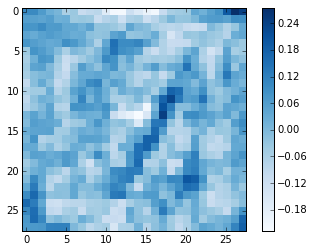

element 452


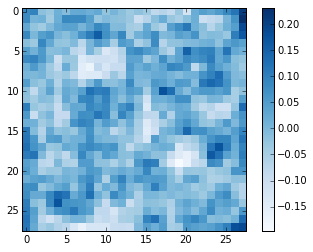

element 456


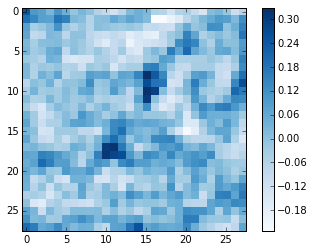

element 460


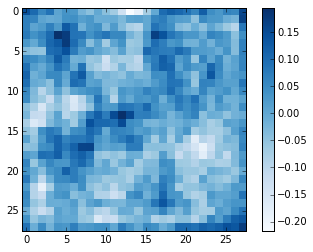

element 464


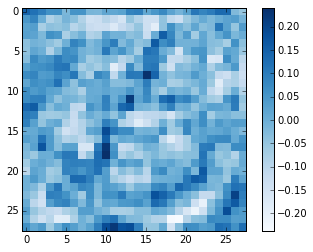

element 468


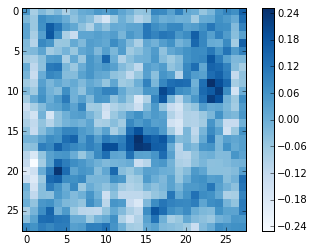

element 472


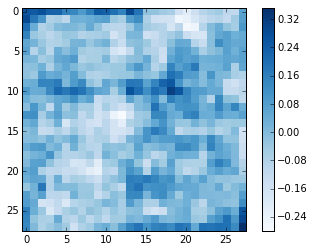

element 476


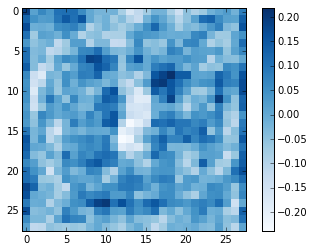

element 480


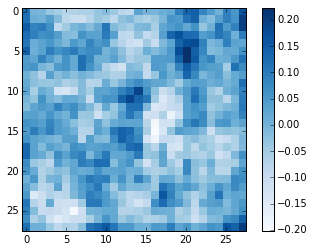

element 484


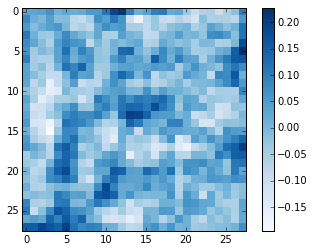

element 488


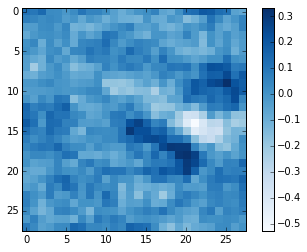

element 492


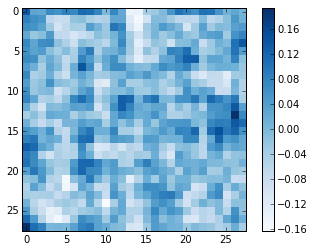

element 496


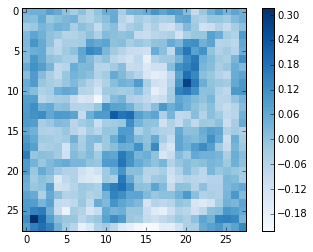

element 500


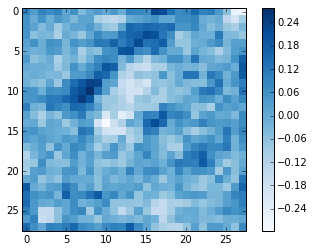

element 504


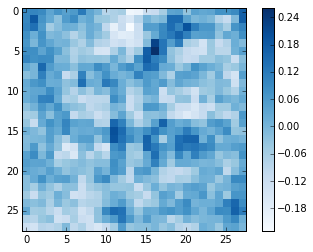

element 508


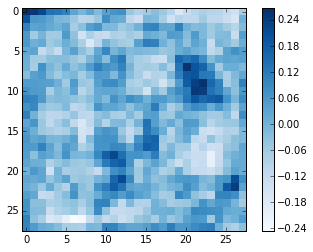

element 512


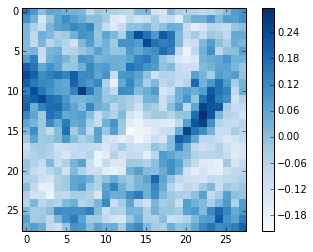

element 516


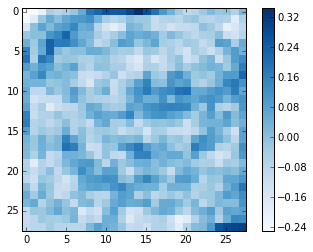

element 520


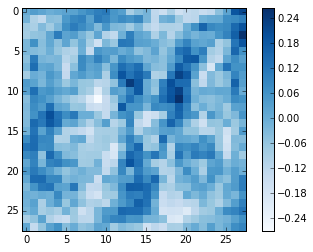

element 524


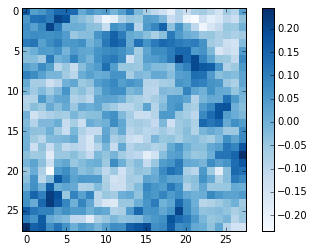

element 528


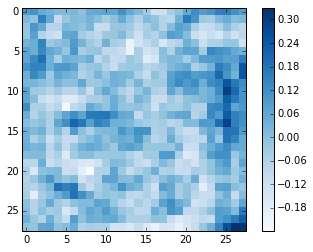

element 532


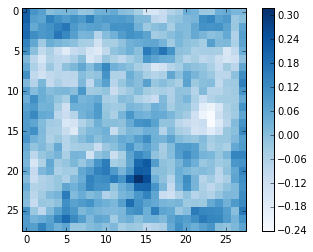

element 536


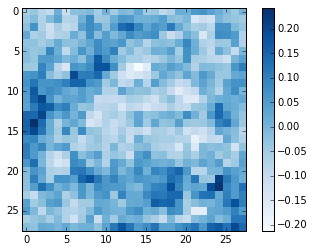

element 540


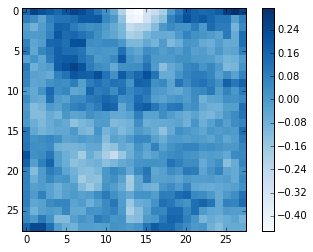

element 544


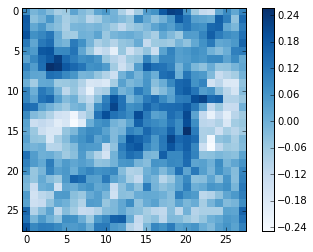

element 548


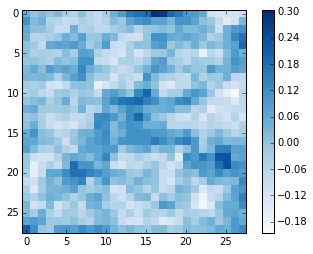

element 552


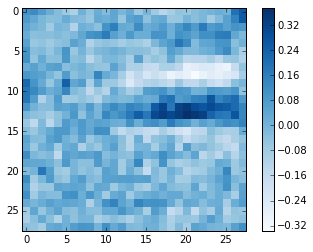

element 556


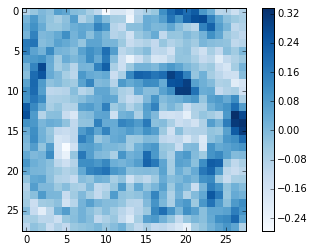

element 560


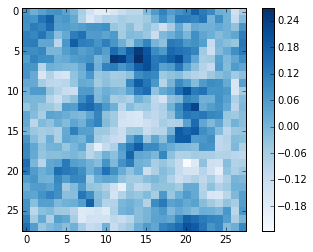

element 564


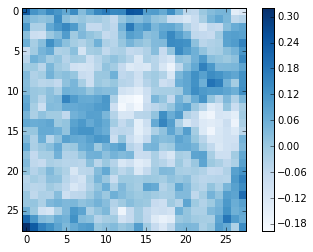

element 568


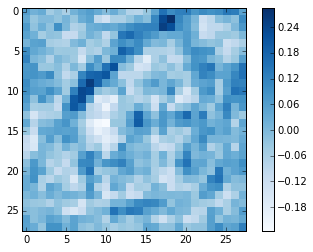

element 572


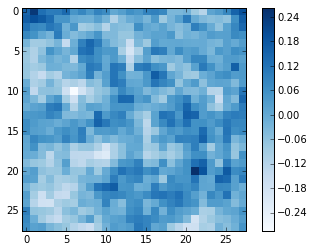

element 576


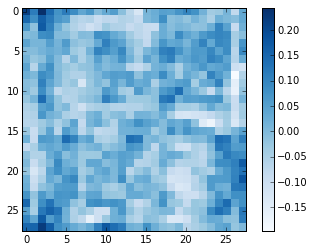

element 580


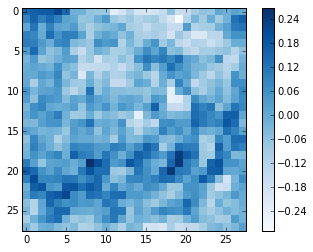

element 584


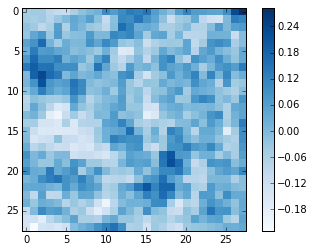

element 588


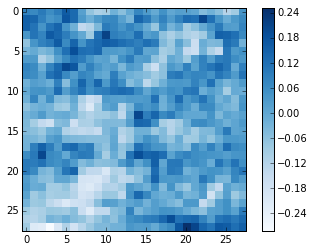

element 592


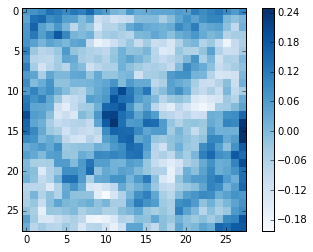

element 596


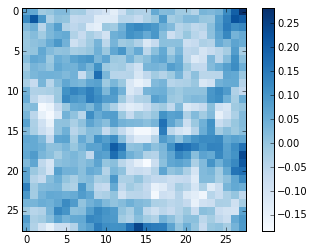

element 600


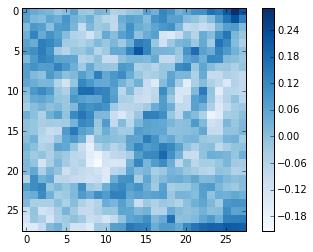

element 604


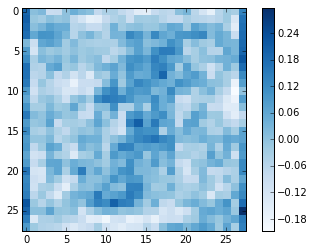

element 608


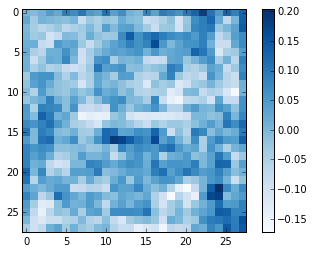

element 612


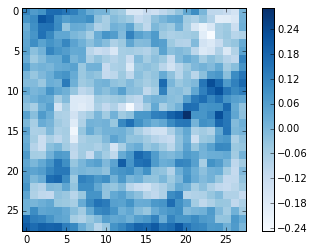

element 616


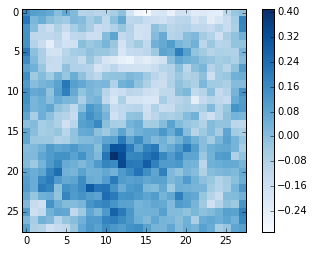

element 620


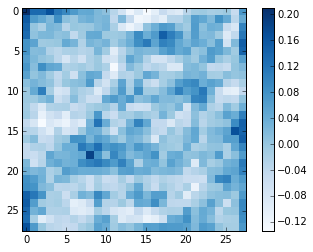

element 624


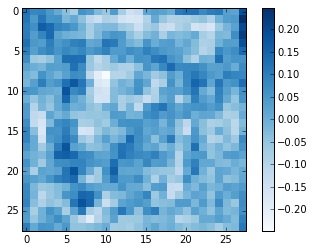

element 628


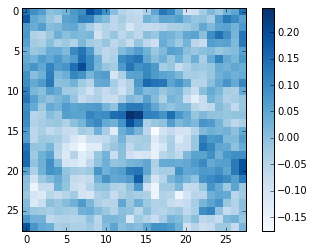

element 632


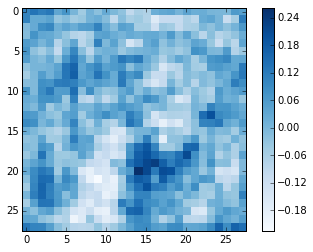

element 636


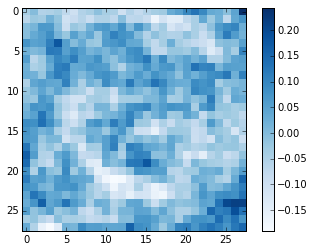

element 640


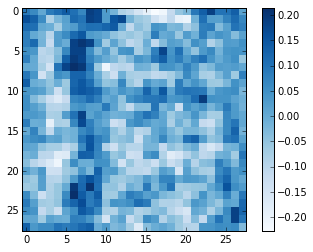

element 644


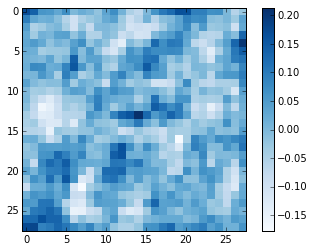

element 648


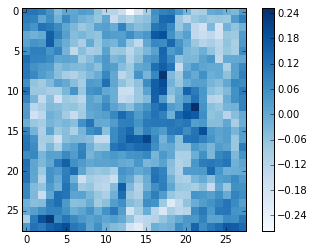

element 652


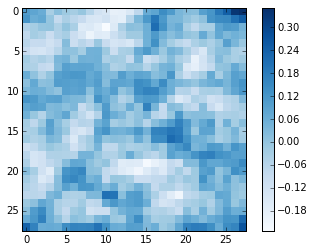

element 656


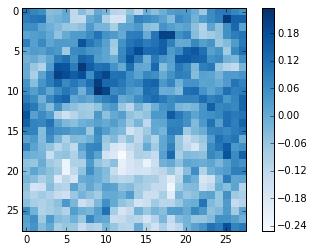

element 660


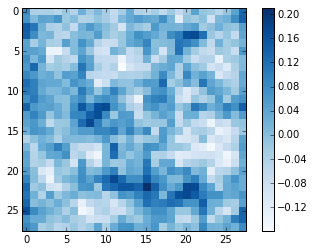

element 664


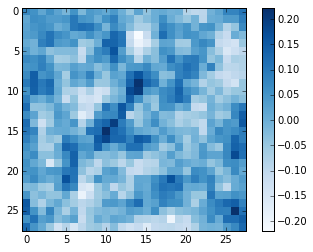

element 668


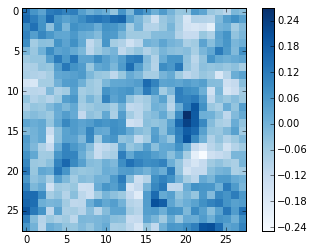

element 672


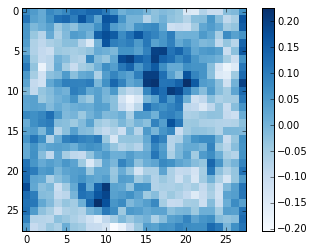

element 676


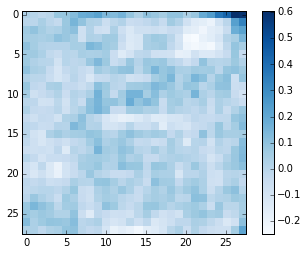

element 680


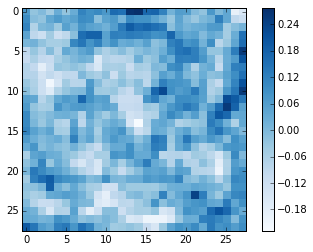

element 684


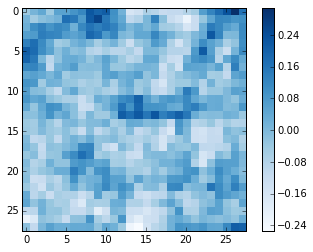

element 688


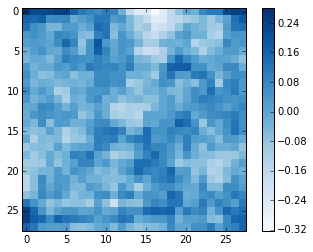

element 692


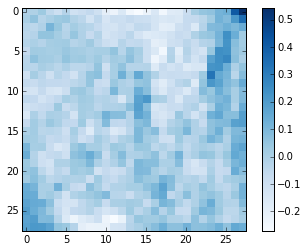

element 696


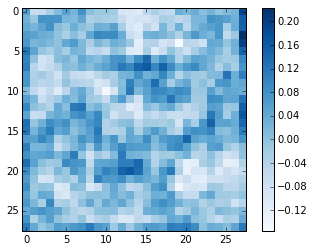

element 700


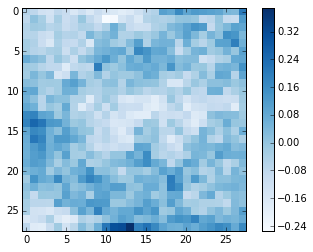

element 704


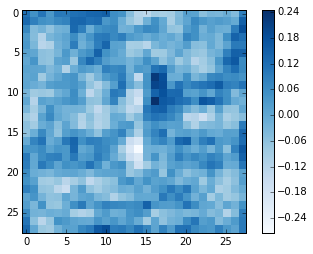

element 708


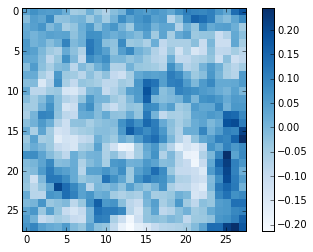

element 712


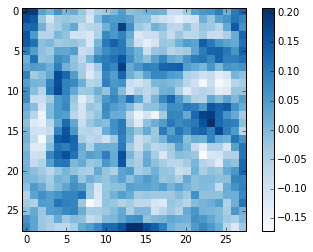

element 716


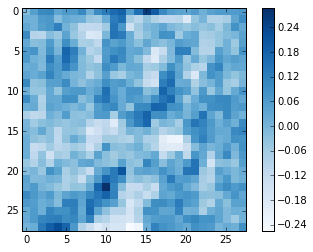

element 720


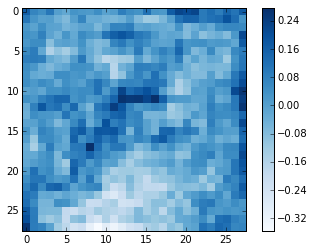

element 724


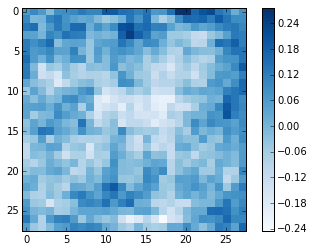

element 728


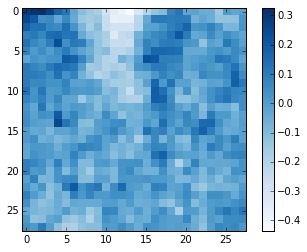

element 732


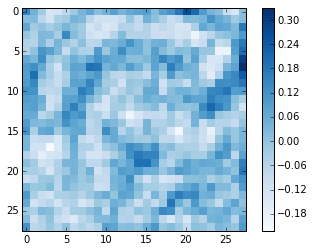

element 736


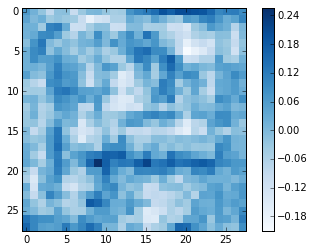

element 740


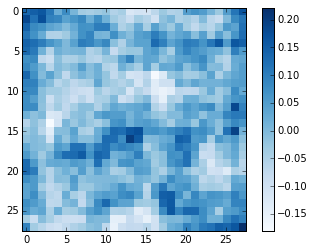

element 744


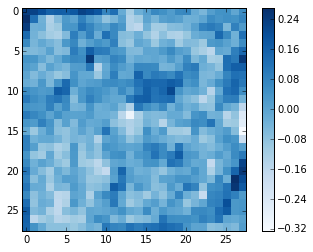

element 748


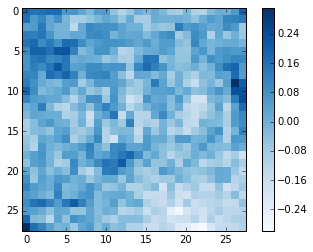

element 752


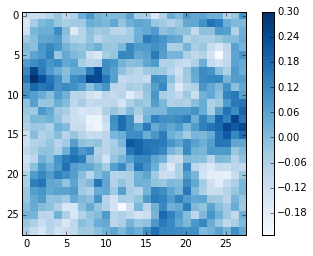

element 756


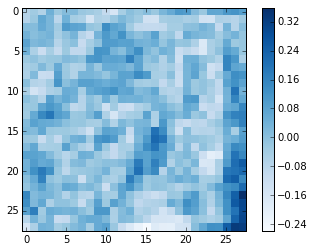

element 760


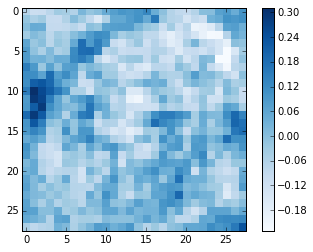

element 764


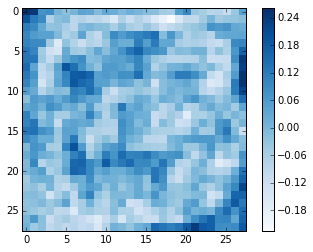

element 768


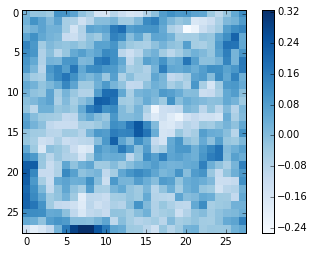

element 772


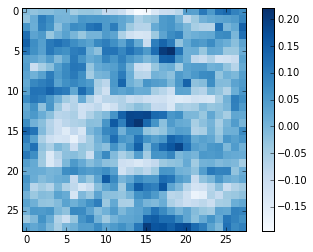

element 776


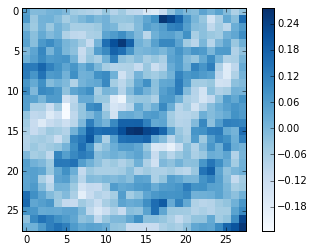

element 780


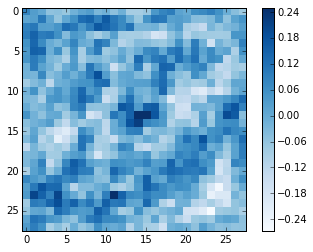

element 784


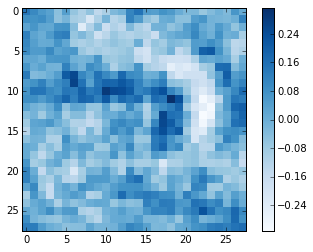

element 788


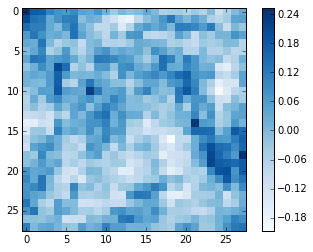

element 792


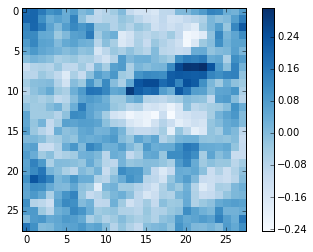

element 796


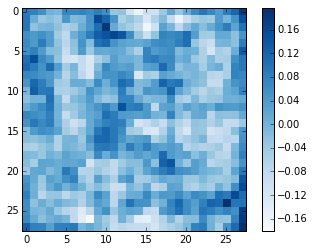

element 800


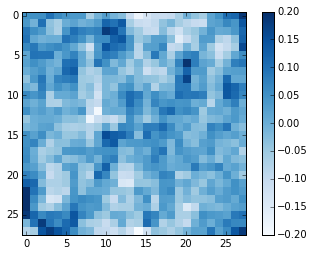

element 804


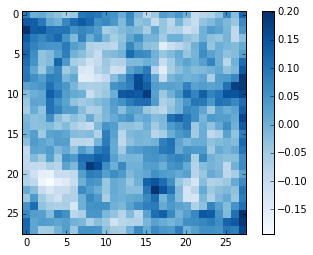

element 808


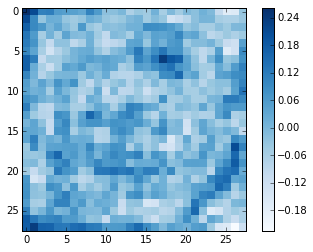

element 812


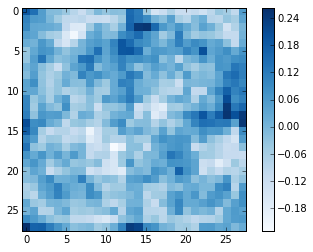

element 816


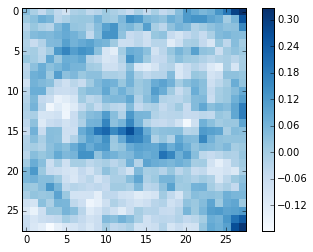

element 820


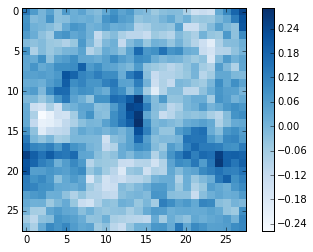

element 824


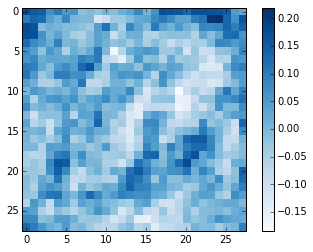

element 828


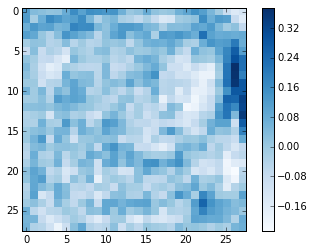

element 832


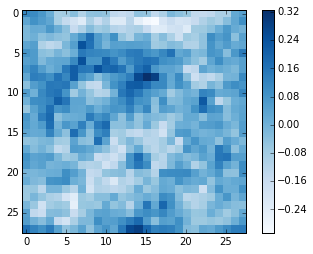

element 836


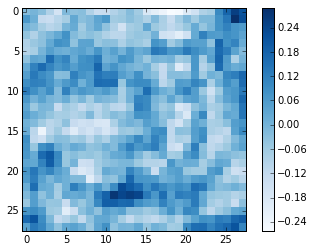

element 840


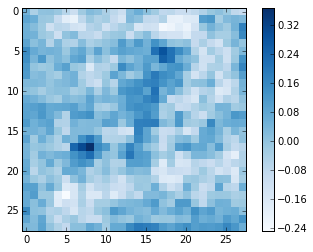

element 844


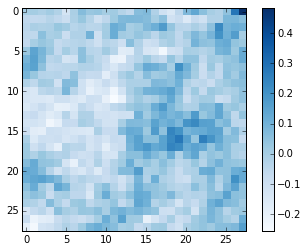

element 848


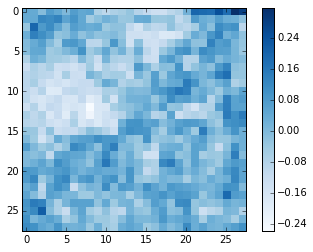

element 852


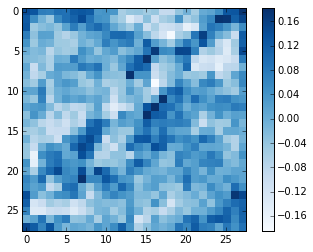

element 856


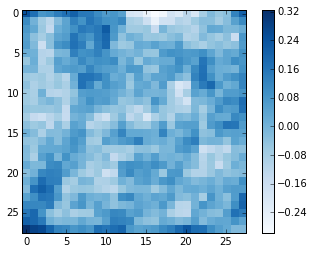

element 860


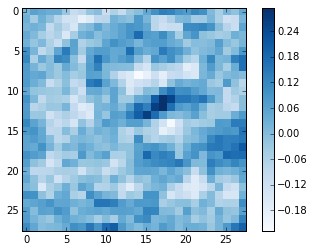

element 864


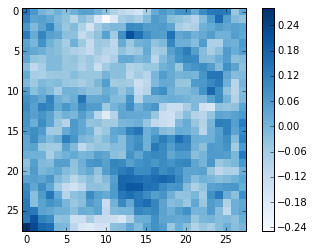

element 868


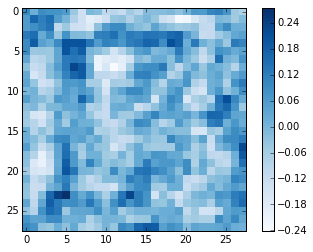

element 872


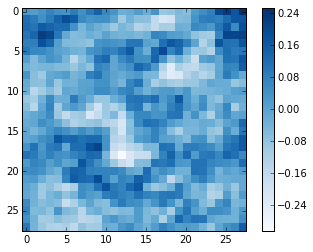

element 876


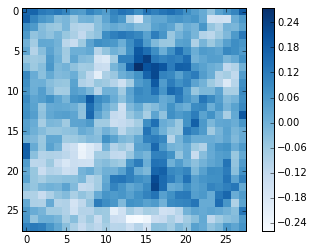

element 880


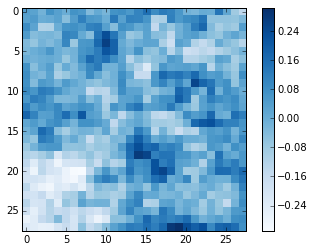

element 884


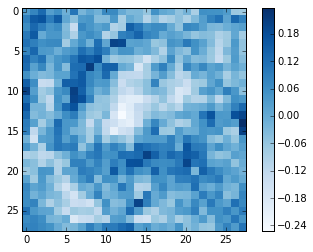

element 888


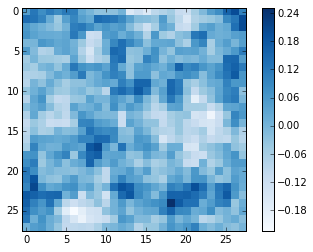

element 892


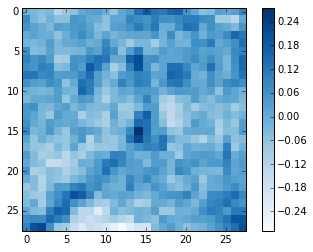

element 896


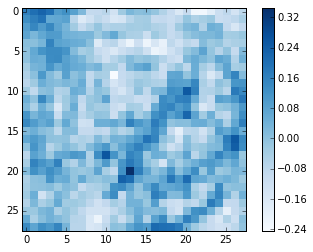

element 900


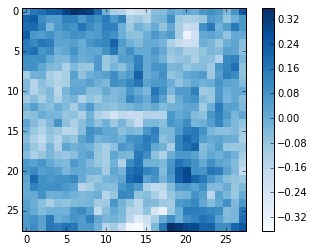

element 904


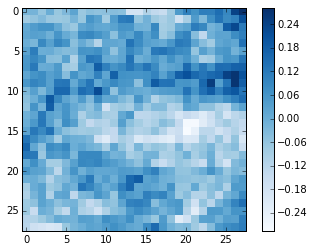

element 908


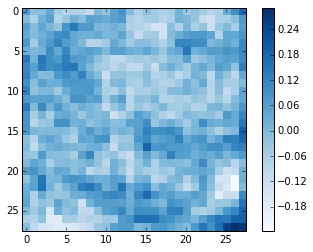

element 912


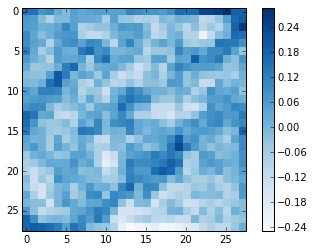

element 916


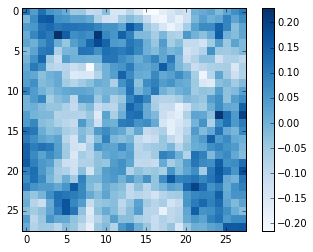

element 920


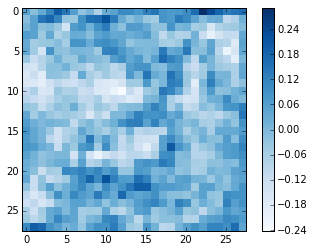

element 924


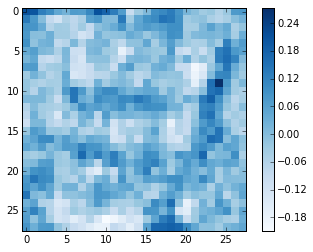

element 928


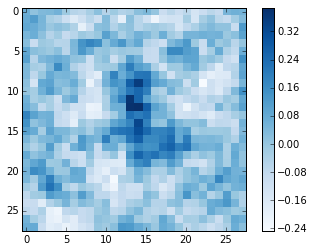

element 932


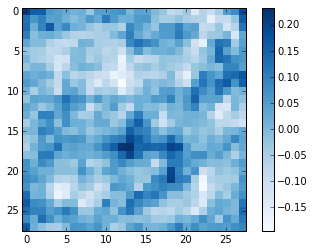

element 936


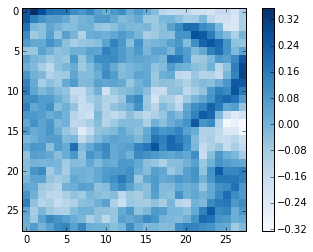

element 940


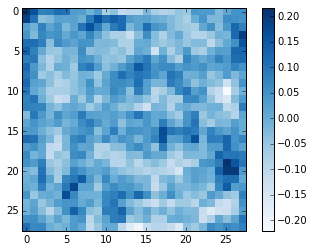

element 944


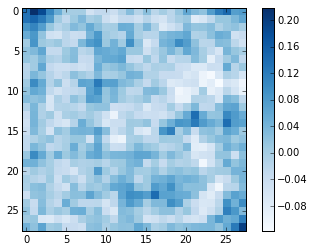

element 948


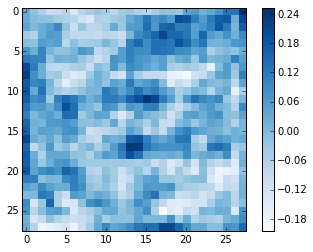

element 952


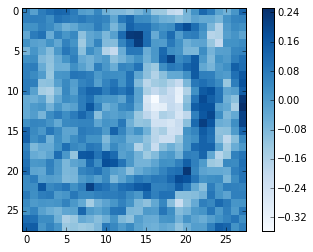

element 956


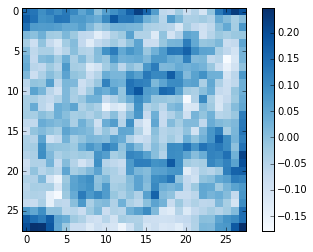

element 960


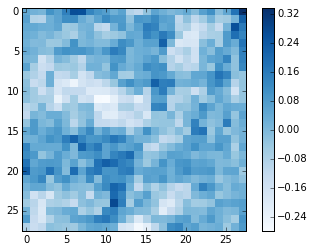

element 964


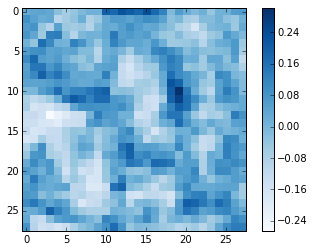

element 968


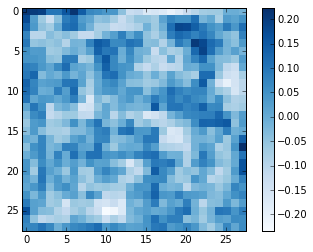

element 972


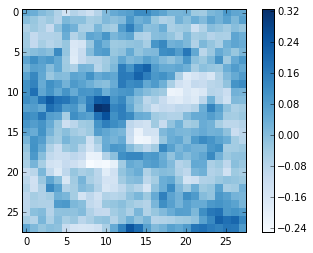

element 976


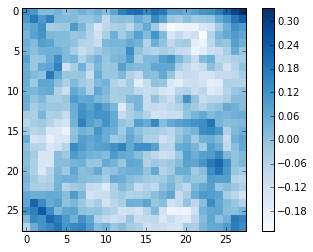

element 980


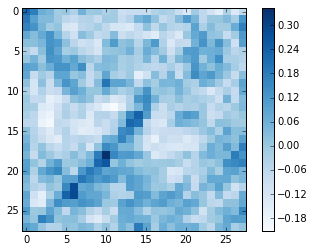

element 984


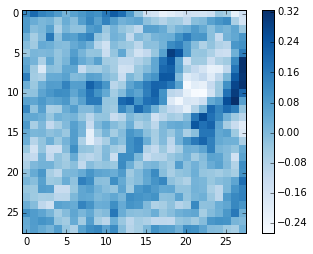

element 988


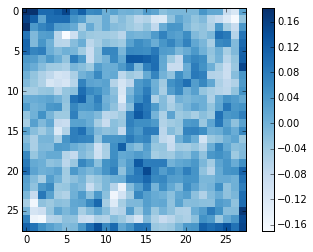

element 992


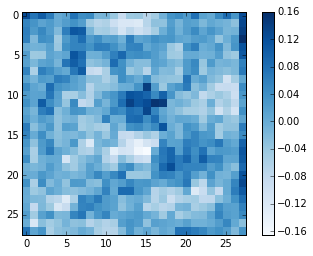

element 996


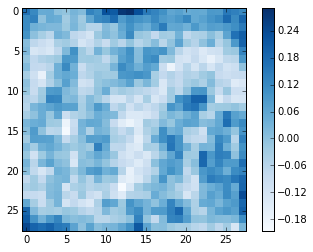

element 1000


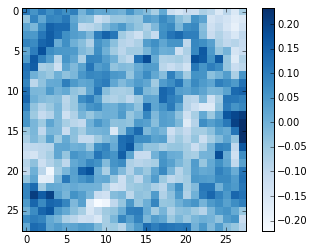

element 1004


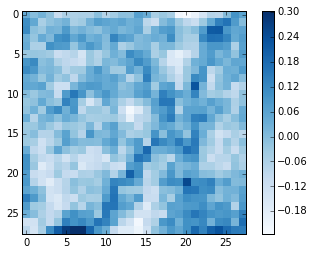

element 1008


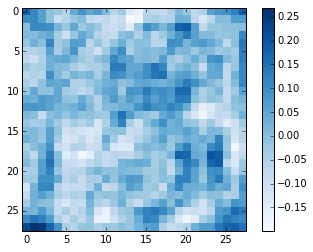

element 1012


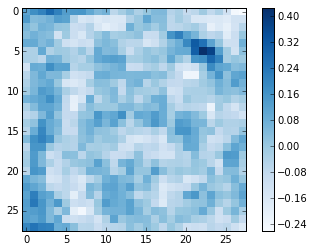

element 1016


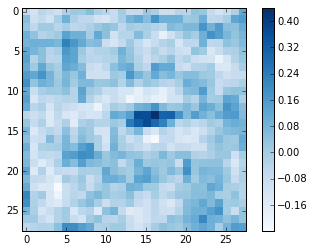

element 1020


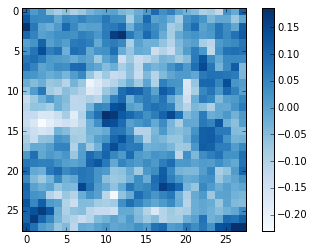

In [173]:
for i in range(0, 1024, 4):
    print 'element', i
    plt.imshow(w1[:, i].reshape(28, 28), interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()